# Edit forcing for single column experiments

We are applying our own forcing to the cingle column experiments. So lets create it

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
from dask.distributed import Client
from scipy.interpolate import interp1d

import xarray as xr
import cf_xarray as cfxr
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath
from matplotlib import gridspec
from PIL import Image
import glob

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44387,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:33535,Total threads: 4
Dashboard: http://127.0.0.1:43595/status,Memory: 143.87 GiB
Nanny: tcp://127.0.0.1:45245,


In [3]:
#defining multiline plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

### **Case 1** - Salt-driven convection: Freshwater fluxes as solely precipitation, Summer T profile

In this case, we want to set up a model without any precipitation and with evaporation equivalent to the evareage of freshwater fluxes in the Inner Weddell Sea.
However evaporation crate latent heat fluxes, and heat fluxes associated to mass exchange that we need to compensate for. The simulations here will compensate the heat flux by adjusting the latent heat of evaporation to amtch the value we want. Check [This code (add code link later))]() to see how was done.

- **Part I**: Run the model for 3 years, with latent heat fluxes adjusted,forced with the proper  $\tau_x$ and $\tau_y$. Do a sanity chec to see if the heat fluxes on 1mtop match what we aim for
- **Part II**: Check differences between 1mtop and 5mtop


##### **Part I**

In [4]:
#original forcing is
src_forc='/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/Original_forcing.nc'
data_orig=xr.open_dataset(src_forc)

0.3.0


In [46]:
#zeroying out all forcings except evaporation
data_evaponly=data_orig.copy()
data_evaponly['precip'].values=np.array(data_orig.precip)*0
data_evaponly['snow'].values=np.array(data_orig.snow)*0
data_evaponly['shflx'].values=np.array(data_orig.shflx)*0
data_evaponly['lwdn_sfc'].values=np.array(data_orig.lwdn_sfc)*0
data_evaponly['lwup_sfc'].values=np.array(data_orig.lwup_sfc)*0
data_evaponly['netlwdn_sfc'].values=np.array(data_orig.netlwdn_sfc)*0
data_evaponly['swdn_sfc'].values=np.array(data_orig.swdn_sfc)*0
data_evaponly['swup_sfc'].values=np.array(data_orig.swup_sfc)*0
data_evaponly['netswdn_sfc'].values=np.array(data_orig.netswdn_sfc)*0

#setting taux and tauy
data_evaponly['STRESS_X'].values=(np.array(data_orig.STRESS_X)*0) - 1.78e-2
data_evaponly['STRESS_Y'].values=(np.array(data_orig.STRESS_Y)*0) + 1.39e-2

#evap will be
data_evaponly['evap'].values=(np.array(data_orig.evap)*0)+7e-5
#second case with stronger FWF found in Weddell Sea
data_evapmax=data_evaponly.copy()
data_evapmax['evap'].values=(np.array(data_orig.evap)*0)+0.0024
#third case with stronger FWF found in Weddell Sea
data_evapdouble=data_evaponly.copy()
data_evapdouble['evap'].values=(np.array(data_orig.evap)*0)+0.0048
#Scenario with a strong FWF, equivalent to the mean FWF along the coast
data_evap01=data_evaponly.copy()
data_evap01['evap'].values=(np.array(data_orig.evap)*0)+0.001
#Scenario with a strong FWF, equivalent to the half FWF along the coast (0.0005)
data_evap005=data_evaponly.copy()
data_evap005['evap'].values=(np.array(data_orig.evap)*0)+0.0005
#Scenario with a strong FWF, equivalent to a quarter FWF along the coast (0.00025)
data_evap0025=data_evaponly.copy()
data_evap0025['evap'].values=(np.array(data_orig.evap)*0)+0.00025
#Scenario with a strong FWF, equivalent to a tenth FWF along the coast (0.00025)
data_evap0001=data_evaponly.copy()
data_evap0001['evap'].values=(np.array(data_orig.evap)*0)+0.0001
#Scenario with a strong FWF, equivalent to the absolute maximum FWF
data_evap015=data_evaponly.copy()
data_evap015['evap'].values=(np.array(data_orig.evap)*0)+0.0015


##snow scenario
#Scenario with a strong FWF, equivalent to the mean FWF along the coast
data_evap01snow=data_evaponly.copy()
data_evap01snow['evap'].values=(np.array(data_orig.evap)*0)
data_evap01snow['snow'].values=(np.array(data_orig.snow)*0)-0.001
#analysis of the snow forcing scenario, with negative snow shows that the model doesnt recognize negative snow. 

##calving scenario
#Scenario with a strong FWF, equivalent to the mean FWF along the coast
data_evap01cal=data_evaponly.copy()
data_evap01cal['evap'].values=(np.array(data_orig.evap)*0)
data_evap01cal['snow'].values=(np.array(data_orig.snow)*0)
calving = data_evap01cal.snow; calving.name='calving'
calving.attrs['long_name']='Calving'
data_evap01cal['calving']=calving
data_evap01cal['calving'].values=(np.array(data_orig.snow)*0)-0.001
#analysis of the calving forcing scenario, with negative snow shows that the model doesnt recognize negative snow. 




In [47]:
#saving it
encoding = {'gridlon_t': {'_FillValue': None},'gridlat_t': {'_FillValue': None},
            'geolon_t': {'_FillValue': None},'geolat_t': {'_FillValue': None},
            'TIME14': {"dtype": "double",'_FillValue': None},'evap': {'_FillValue': None},
            'precip': {'_FillValue': None},'snow': {'_FillValue': None},
            'shflx': {'_FillValue': None},'lwdn_sfc': {'_FillValue': None},
            'lwup_sfc': {'_FillValue': None},'netlwdn_sfc': {'_FillValue': None},
            'swdn_sfc': {'_FillValue': None},'swup_sfc': {'_FillValue': None},
            'netswdn_sfc': {'_FillValue': None},'STRESS_X': {'_FillValue': None},
            'STRESS_Y': {'_FillValue': None}
            }


encodingc = {'gridlon_t': {'_FillValue': None},'gridlat_t': {'_FillValue': None},
            'geolon_t': {'_FillValue': None},'geolat_t': {'_FillValue': None},
            'TIME14': {"dtype": "double",'_FillValue': None},'evap': {'_FillValue': None},
            'precip': {'_FillValue': None},'snow': {'_FillValue': None},
            'shflx': {'_FillValue': None},'lwdn_sfc': {'_FillValue': None},
            'lwup_sfc': {'_FillValue': None},'netlwdn_sfc': {'_FillValue': None},
            'swdn_sfc': {'_FillValue': None},'swup_sfc': {'_FillValue': None},
            'netswdn_sfc': {'_FillValue': None},'STRESS_X': {'_FillValue': None},
            'STRESS_Y': {'_FillValue': None},'calving': {'_FillValue': None}
            }

data_evaponly.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_evapmax.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only0024.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_evapdouble.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only0048.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_evap01.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only001.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_evap005.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only0005.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_evap0025.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only00025.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_evap0001.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only0001.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_evap01snow.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only001_snow.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_evap01cal.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only001_calving.nc',format="NETCDF3_CLASSIC",encoding=encodingc)
data_evap015.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_evap_only0015.nc',format="NETCDF3_CLASSIC",encoding=encoding)

Now let's set up the initial conditions. We can create just one IC for 1mtop and 5mtop cases, the model interpolates the IC for the target zgrid

In [7]:
#original IC is
src_IC='/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/Original_WOA_column.nc'
IC_orig=xr.open_dataset(src_IC,decode_times=False)


Weddell_srcIC='/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/local_input/Weddell_ICs_z.nc'
IC_WeddellIn=xr.open_dataset(Weddell_srcIC)

WeddellOff_srcIC='/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/local_input/Weddelloffshore_ICs_z.nc'
ICoff_WeddellIn=xr.open_dataset(WeddellOff_srcIC)

In [8]:
############   shelf conditions
#Creating the new IC conditons
IC_Weddell_out = IC_orig.copy()
#setting boundaries. This is important so we can input the proper Lon and Lat on MOM_input
IC_Weddell_out['LAT']=[-85,85]
IC_Weddell_out['LON']=[-180,180]
# expanding the number of depth levels and setting the corrent values for PTEMP and SALT
IC_Weddell_out = IC_Weddell_out.interp(DEPTH=np.array(IC_WeddellIn.st_ocean))
IC_Weddell_out['PTEMP'].values=np.transpose(np.tile(np.array(IC_WeddellIn.PTemp),[12,2,2,1]),[0,3,1,2])
IC_Weddell_out['PTEMP'].values=IC_Weddell_out.PTEMP.ffill(dim='DEPTH')
IC_Weddell_out['SALT'].values=np.transpose(np.tile(np.array(IC_WeddellIn.Salinity),[12,2,2,1]),[0,3,1,2])
IC_Weddell_out['SALT'].values=IC_Weddell_out.SALT.ffill(dim='DEPTH')
#setting Boundary depths
boundaries_St=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_KDS75.nc').st_edges_ocean
boundaries_St=np.array([np.array(boundaries_St[:-1]), np.array(boundaries_St[1:])]).T
IC_Weddell_out['DEPTH_bnds'].values=boundaries_St



############   Weddell offshore conditions
#Creating the new IC conditons
ICoff_Weddell_out = IC_orig.copy()
#setting boundaries. This is important so we can input the proper Lon and Lat on MOM_input
ICoff_Weddell_out['LAT']=[-85,85]
ICoff_Weddell_out['LON']=[-180,180]
# expanding the number of depth levels and setting the corrent values for PTEMP and SALT
ICoff_Weddell_out = ICoff_Weddell_out.interp(DEPTH=np.array(ICoff_WeddellIn.st_ocean))
ICoff_Weddell_out['PTEMP'].values=np.transpose(np.tile(np.array(ICoff_WeddellIn.PTemp),[12,2,2,1]),[0,3,1,2])
ICoff_Weddell_out['PTEMP'].values=ICoff_Weddell_out.PTEMP.ffill(dim='DEPTH')
ICoff_Weddell_out['SALT'].values=np.transpose(np.tile(np.array(ICoff_WeddellIn.Salinity),[12,2,2,1]),[0,3,1,2])
ICoff_Weddell_out['SALT'].values=ICoff_Weddell_out.SALT.ffill(dim='DEPTH')
#setting Boundary depths
boundaries_St=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_KDS75.nc').st_edges_ocean
boundaries_St=np.array([np.array(boundaries_St[:-1]), np.array(boundaries_St[1:])]).T
ICoff_Weddell_out['DEPTH_bnds'].values=boundaries_St

In [9]:
Wencoding = {'LON': {"dtype": "double",'_FillValue': None},'LAT': {"dtype": "double",'_FillValue': None},
            'DEPTH': {"dtype": "double",'_FillValue': None},'TIME': {"dtype": "double",'_FillValue': None},
            'PTEMP': {"dtype": "float",'_FillValue': -1.e+34},
            'SALT': {"dtype": "float",'_FillValue': -1.e+34},
            'TIME_bnds': {"dtype": "double",'_FillValue': None}
            }
IC_Weddell_out.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/Weddell_OM2_columnIC.nc',format="NETCDF3_CLASSIC",encoding=Wencoding)
ICoff_Weddell_out.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/WeddellOffshore_OM2_columnIC.nc',format="NETCDF3_CLASSIC",encoding=Wencoding)

Now lets create a 1km vertical grid to simulate the depth of Antarctic shelf

In [51]:
#original KDS grid with 6 km depth
kds_6km = xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_KDS75.nc')
#new KDS grid 1mtop with 1km depth
depth_slice=slice(0,1070)
kds_1km = kds_6km.copy().sel(st_ocean=depth_slice).sel(st_edges_ocean=depth_slice)
kds_1km.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_KDS75_1km.nc')
#new KDS grid 1mtop with 500m depth
depth_slice2=slice(0,500)
kds_500m = kds_6km.copy().sel(st_ocean=depth_slice2).sel(st_edges_ocean=depth_slice2)
kds_500m.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_KDS75_500m.nc')
#new KDS grid 1mtop with 250m depth
depth_slice2=slice(0,250)
kds_250m = kds_6km.copy().sel(st_ocean=depth_slice2).sel(st_edges_ocean=depth_slice2)
kds_250m.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_KDS75_250m.nc')


#new KDS grid 5mtop
kds_5mtop_6km=  xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_5mtop.nc')
kds_5mtop_1km = kds_5mtop_6km.copy().sel(st_ocean=depth_slice).sel(st_edges_ocean=depth_slice)
kds_5mtop_1km.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_5mtop_1km.nc')
#new KDS grid 1mtop with 500m depth
depth_slice2=slice(0,500)
kds_5mtop_500m = kds_5mtop_6km.copy().sel(st_ocean=depth_slice2).sel(st_edges_ocean=depth_slice2)
kds_5mtop_500m.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_5mtop_500m.nc')
#new KDS grid 1mtop with 250m depth
depth_slice2=slice(0,250)
kds_5mtop_250m = kds_5mtop_6km.copy().sel(st_ocean=depth_slice2).sel(st_edges_ocean=depth_slice2)
kds_5mtop_250m.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_5mtop_250m.nc')


<xarray.Dataset>
Dimensions:         (st_edges_ocean: 30, st_ocean: 29)
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 5.062 6.677 ... 217.4 241.2
  * st_ocean        (st_ocean) float64 2.531 5.869 7.569 ... 186.1 206.6 229.3
Data variables:
    *empty*
Attributes:
    filename:   ocean.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    Thu Jan 21 08:51:33 2021: ncks -v st_ocean,st_edges_ocean /g/...
    NCO:        netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net,...

After running, we get the following output data. Let's do a quick sanity check

In [48]:
####### 1mtop experiments

#importing surfae forcing data
surffluxesIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/surffluxes.nc')
surffluxesIW0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0001_latent/surffluxes.nc')
surffluxesIW00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_00025_latent/surffluxes.nc')
surffluxesIW0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0005_latent/surffluxes.nc')
surffluxesIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent/surffluxes.nc')
surffluxesIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent/surffluxes.nc')

# Importing output vars
##aveprog
ave_progIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/ave_prog.nc')
ave_progIW0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0001_latent/ave_prog.nc')
ave_progIW00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_00025_latent/ave_prog.nc')
ave_progIW0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0005_latent/ave_prog.nc')
ave_progIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent/ave_prog.nc')
ave_progIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent/ave_prog.nc')

##prog
progIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/prog.nc')
progIW0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0001_latent/prog.nc')
progIW00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_00025_latent/prog.nc')
progIW0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0005_latent/prog.nc')
progIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent/prog.nc')
progIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent/prog.nc')


##progz
progzIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/prog_z.nc')
progzIW0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0001_latent/prog_z.nc')
progzIW00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_00025_latent/prog_z.nc')
progzIW0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0005_latent/prog_z.nc')
progzIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent/prog_z.nc')
progzIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent/prog_z.nc')

##visc
viscIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/visc.nc')
viscIW0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0001_latent/visc.nc')
viscIW00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_00025_latent/visc.nc')
viscIW0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0005_latent/visc.nc')
viscIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent/visc.nc')
viscIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent/visc.nc')

##static
statsIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/ocean.stats.nc')
statsIW0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0001_latent/ocean.stats.nc')
statsIW00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_00025_latent/ocean.stats.nc')
statsIW0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0005_latent/ocean.stats.nc')
statsIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent/ocean.stats.nc')
statsIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent/ocean.stats.nc')


In [66]:
####### 1mtop and 5mtop experiments with stronger winds and offshore water column conditions, and with shallower sshelf

#importing surfae forcing data
OsurffluxesIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent_offshore/surffluxes.nc')
MsurffluxesIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent_mixing/surffluxes.nc')
OsurffluxesIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent_offshore/surffluxes.nc')
MsurffluxesIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent_mixing/surffluxes.nc')
S250surffluxesIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_250m_WeddelIC_001_latent/surffluxes.nc')
S250surffluxesIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_250m_WeddelIC_001_latent/surffluxes.nc')

# Importing output vars
##aveprog
Oave_progIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent_offshore/ave_prog.nc')
Mave_progIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent_mixing/ave_prog.nc')
Oave_progIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent_offshore/ave_prog.nc')
Mave_progIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent_mixing/ave_prog.nc')
S250ave_progIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_250m_WeddelIC_001_latent/ave_prog.nc')
S250ave_progIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_250m_WeddelIC_001_latent/ave_prog.nc')

##prog
OprogIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent_offshore/prog.nc')
MprogIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent_mixing/prog.nc')
OprogIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent_offshore/prog.nc')
MprogIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent_mixing/prog.nc')
S250progIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_250m_WeddelIC_001_latent/prog.nc')
S250progIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_250m_WeddelIC_001_latent/prog.nc')

##progz
OprogzIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent_offshore/prog_z.nc')
MprogzIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent_mixing/prog_z.nc')
OprogzIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent_offshore/prog_z.nc')
MprogzIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent_mixing/prog_z.nc')
S250progzIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_250m_WeddelIC_001_latent/prog_z.nc')
S250progzIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_250m_WeddelIC_001_latent/prog_z.nc')


##visc
OviscIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent_offshore/visc.nc')
MviscIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent_mixing/visc.nc')
OviscIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent_offshore/visc.nc')
MviscIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent_mixing/visc.nc')
S250viscIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_250m_WeddelIC_001_latent/visc.nc')
S250viscIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_250m_WeddelIC_001_latent/visc.nc')

##static
OstatsIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_001_latent_offshore/ocean.stats.nc')
MstatsIW0015=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_0015_latent_mixing/ocean.stats.nc')
OstatsIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent_offshore/ocean.stats.nc')
MstatsIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent_mixing/ocean.stats.nc')
S250statsIW001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_250m_WeddelIC_001_latent/ocean.stats.nc')
S250statsIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_250m_WeddelIC_001_latent/ocean.stats.nc')


In [53]:
####### 5mtop experiments

#importing surfae forcing data
surffluxesIW7em5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_7em5_latent/surffluxes.nc')
surffluxesIW0001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0001_latent/surffluxes.nc')
surffluxesIW00025_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_00025_latent/surffluxes.nc')
surffluxesIW0005_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0005_latent/surffluxes.nc')
surffluxesIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent/surffluxes.nc')
surffluxesIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent/surffluxes.nc')

# Importing output vars
##aveprog
ave_progIW7em5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_7em5_latent/ave_prog.nc')
ave_progIW0001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0001_latent/ave_prog.nc')
ave_progIW00025_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_00025_latent/ave_prog.nc')
ave_progIW0005_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0005_latent/ave_prog.nc')
ave_progIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent/ave_prog.nc')
ave_progIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent/ave_prog.nc')

##prog
progIW7em5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_7em5_latent/prog.nc')
progIW0001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0001_latent/prog.nc')
progIW00025_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_00025_latent/prog.nc')
progIW0005_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0005_latent/prog.nc')
progIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent/prog.nc')
progIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent/prog.nc')

##progz
progzIW7em5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_7em5_latent/prog_z.nc')
progzIW0001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0001_latent/prog_z.nc')
progzIW00025_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_00025_latent/prog_z.nc')
progzIW0005_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0005_latent/prog_z.nc')
progzIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent/prog_z.nc')
progzIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent/prog_z.nc')


##visc
viscIW7em5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_7em5_latent/visc.nc')
viscIW0001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0001_latent/visc.nc')
viscIW00025_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_00025_latent/visc.nc')
viscIW0005_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0005_latent/visc.nc')
viscIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent/visc.nc')
viscIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent/visc.nc')


##static
statsIW7em5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_7em5_latent/ocean.stats.nc')
statsIW0001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0001_latent/ocean.stats.nc')
statsIW00025_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_00025_latent/ocean.stats.nc')
statsIW0005_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0005_latent/ocean.stats.nc')
statsIW001_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_001_latent/ocean.stats.nc')
statsIW0015_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_500m_WeddelIC_0015_latent/ocean.stats.nc')


It seems that the salt content in the model doesnt really change ( change is 250g in 1e12 kg, so almost nothing)

In [14]:
# time_sliceshort=slice(0,30,1)

# Temp_subsampled = ave_progI0024.temp.mean(['xh','yh']).isel(Time=time_sliceshort) #subsampling for every 30 days

# Temp_subsampledcomp = ave_progIlatent.temp.mean(['xh','yh']).isel(Time=time_sliceshort) #subsampling for every 30 days
# Salt_subsampled = ave_progI0024.salt.mean(['xh','yh']).isel(Time=time_sliceshort) #subsampling for every 30 days
# depth_multi=np.tile(ave_progI0024.zl,[30,1]) 
# yint = np.arange(0, 30, 1) #color range

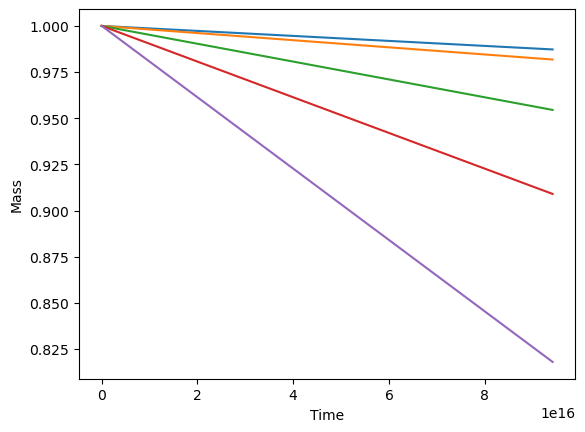

In [15]:
(statsIW7em5.Mass/statsIW7em5.Mass.max()).plot()
(statsIW0001.Mass/statsIW0001.Mass.max()).plot()
(statsIW00025.Mass/statsIW00025.Mass.max()).plot()
(statsIW0005.Mass/statsIW0005.Mass.max()).plot()
(statsIW001.Mass/statsIW001.Mass.max()).plot()

Top plot shows that in the highest FWF cases, mass changes seem to not be very ideal. I wonder how does that wornk on OM@, since these FWF are actually from OM2

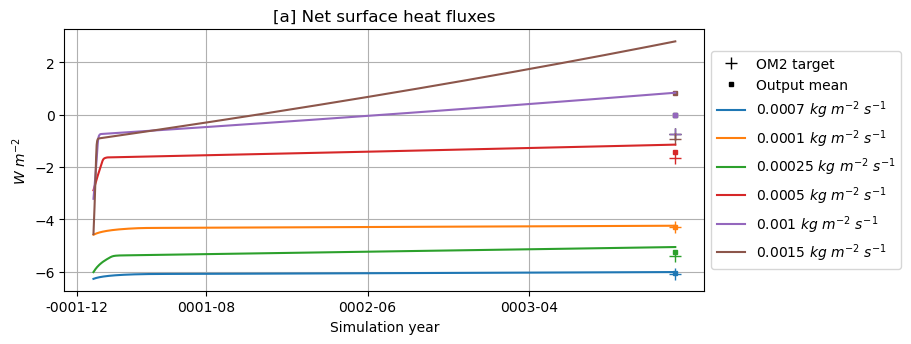

In [55]:
# how does the surface fluxes look like?

fig  = plt.figure(figsize = (8, 8))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

ax1 = plt.subplot(2,1,1)
lastday=1095
timedays=range(0,lastday)
#target values
plt.plot(surffluxesIW7em5.net_heat_surface.Time.isel(Time=-1),-6.1,marker='+',color='tab:blue',markersize=8)
plt.plot(surffluxesIW7em5.net_heat_surface.Time.isel(Time=-1),\
         float(surffluxesIW7em5.net_heat_surface.mean()),marker='s',color='tab:blue',markersize=3)

plt.plot(surffluxesIW0001.net_heat_surface.Time.isel(Time=-1),-4.3,marker='+',color='tab:orange',markersize=8)
plt.plot(surffluxesIW0001.net_heat_surface.Time.isel(Time=-1),\
         float(surffluxesIW0001.net_heat_surface.mean()),marker='s',color='tab:orange',markersize=3)

plt.plot(surffluxesIW00025.net_heat_surface.Time.isel(Time=-1),-5.39,marker='+',color='tab:green',markersize=8)
plt.plot(surffluxesIW00025.net_heat_surface.Time.isel(Time=-1),\
         float(surffluxesIW00025.net_heat_surface.mean()),marker='s',color='tab:green',markersize=3)

plt.plot(surffluxesIW0005.net_heat_surface.Time.isel(Time=-1),-1.635,marker='+',color='tab:red',markersize=8)
plt.plot(surffluxesIW0005.net_heat_surface.Time.isel(Time=-1),\
         float(surffluxesIW0005.net_heat_surface.mean()),marker='s',color='tab:red',markersize=3)

plt.plot(surffluxesIW001.net_heat_surface.Time.isel(Time=-1),-0.743,marker='+',color='tab:purple',markersize=8)
plt.plot(surffluxesIW001.net_heat_surface.Time.isel(Time=-1),\
         float(surffluxesIW001.net_heat_surface.mean()),marker='s',color='tab:purple',markersize=3)

plt.plot(surffluxesIW0015.net_heat_surface.Time.isel(Time=-1),-0.922,marker='+',color='tab:brown',markersize=8)
plt.plot(surffluxesIW0015.net_heat_surface.Time.isel(Time=-1),\
         float(surffluxesIW0015.net_heat_surface.mean()),marker='s',color='tab:brown',markersize=3)

plt.plot(surffluxesIW001.net_heat_surface.Time.isel(Time=-1),-0.743,\
         linewidth=0,marker='+',color='black',markersize=8,zorder=0,label='OM2 target')
plt.plot(surffluxesIW001.net_heat_surface.Time.isel(Time=-1),\
         float(surffluxesIW001.net_heat_surface.mean()),\
         linewidth=0,marker='s',color='black',markersize=3,zorder=0,label='Output mean')



#surffluxesI0024.net_heat_surface.mean(['xh','yh']).plot(label=r"Net surface heat fluxes")
surffluxesIW7em5.net_heat_surface.mean(['xh','yh']).plot(label=r"0.0007 $kg\ m^{-2}\ s^{-1}$",color='tab:blue')
surffluxesIW0001.net_heat_surface.mean(['xh','yh']).plot(label=r"0.0001 $kg\ m^{-2}\ s^{-1}$",color='tab:orange')
surffluxesIW00025.net_heat_surface.mean(['xh','yh']).plot(label=r"0.00025 $kg\ m^{-2}\ s^{-1}$",color='tab:green')
surffluxesIW0005.net_heat_surface.mean(['xh','yh']).plot(label=r"0.0005 $kg\ m^{-2}\ s^{-1}$",color='tab:red')
surffluxesIW001.net_heat_surface.mean(['xh','yh']).plot(label=r"0.001 $kg\ m^{-2}\ s^{-1}$",color='tab:purple')
surffluxesIW0015.net_heat_surface.mean(['xh','yh']).plot(label=r"0.0015 $kg\ m^{-2}\ s^{-1}$",color='tab:brown')

box = ax1.get_position()

plt.ylabel(r"$W\ m^{-2}$"); plt.xlabel('Simulation year'); plt.title('[a] Net surface heat fluxes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); plt.grid()


In the model, Net surface fluxes are = *SW+LW+lat+sens+mass transfer+frazil+restore+seaice_melt_heat or flux adjustments*

we have disable frazil heat fluxes, and have disable restoring conditions and flux adjustments. Using the approach of adjusting the latent heat of evaporation we matched the values of the heat fluxes to the target ones extracted from OM2 at the weddell sea for the control experiment

Notice that the approach roughly works, and the biggest difference visualy in heat fluxes happens in the highest FWF scenario, which has near zero heat fluxes anyways. so it is likely that they wouldnt even matter

##### **Part II**

Let's now use *Heat_PmE* to compensate for the heat fluxes fue to mass loss, and set up the full Weddell Evaporation experiment. Notice that the heat fluxes equilibrate to the SST only after two years, and we have a yearly forcing. I will used the fluxes in the last year, which are equilibrated, but slightly higher. That coul sound like  a bias, but the  heat fluxes due to mass exchage (~$0.5\ W\ m^{-2}$) is just much smaller then the forcing one (~$6.1\ W\ m^{-2}$), so this might be a irrelevant problem


Note for myself: Check if the heat fluxes from panana relative to $0^oC$ like in the single column, or if they are relative to Kelvins

In [ ]:
# #zeroying out all forcings except evaporation
# data_WeddelEXP=data_orig.copy()
# data_WeddelEXP['precip'].values=np.array(data_orig.precip)*0
# data_WeddelEXP['snow'].values=np.array(data_orig.snow)*0
# data_WeddelEXP['shflx'].values=((np.array(data_orig.shflx)*0) - np.array(surffluxesI.Heat_PmE.isel(Time=slice(3650-365,3650)))) +6.1
# data_WeddelEXP['lwdn_sfc'].values=np.array(data_orig.lwdn_sfc)*0
# data_WeddelEXP['lwup_sfc'].values=np.array(data_orig.lwup_sfc)*0
# data_WeddelEXP['netlwdn_sfc'].values=np.array(data_orig.netlwdn_sfc)*0
# data_WeddelEXP['swdn_sfc'].values=np.array(data_orig.swdn_sfc)*0
# data_WeddelEXP['swup_sfc'].values=np.array(data_orig.swup_sfc)*0
# data_WeddelEXP['netswdn_sfc'].values=np.array(data_orig.netswdn_sfc)*0

# #setting taux and tauy
# data_WeddelEXP['STRESS_X'].values=(np.array(data_orig.STRESS_X)*0) - 1.78e-2
# data_WeddelEXP['STRESS_Y'].values=(np.array(data_orig.STRESS_Y)*0) + 1.39e-2

# #evap will be
# data_WeddelEXP['evap'].values=(np.array(data_orig.shflx)*0)+7e-5
# data_WeddelEXP['shflx'].values=((np.array(data_orig.shflx)*0) - np.array(surffluxesI.Heat_PmE.isel(Time=slice(3650-365,3650)))) +6.1

# #second case with stronger FWF found in Weddell Sea
# data_WeddelEXPmax=data_WeddelEXP.copy()
# data_WeddelEXPmax['evap'].values=(np.array(data_orig.shflx)*0)+0.0024
# data_WeddelEXPmax['shflx'].values=((np.array(data_orig.shflx)*0) - np.array(surffluxesI0024.Heat_PmE.isel(Time=slice(3650-365,3650)))) +6.1
# #third case with doubled stronger FWF found in Weddell Sea 0.0048


In [ ]:
# data_WeddelEXP.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_Saltdriven_convection_1km.nc',format="NETCDF3_CLASSIC",encoding=encoding)
# data_WeddelEXPmax.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_Saltdriven_convection_1km0024.nc',format="NETCDF3_CLASSIC",encoding=encoding)

##### **Part II new**

Now we have the 1mtop and 5mtop single column model, with convection forced by evaporation onl y (I.e., Weddell Sea Analogue case). Let's see how MLD and density over the upper layer changes between models along the simulations

In [56]:
# we will need the dz to average properties
depth_slice=slice(0,50)
depth_slice1=slice(0,55)
#1mtop
dz1full=ave_progIW0001.zi.diff(dim='zi'); dz1full.name='dz'
dz1full=dz1full.rename({'zi':'zl'})
dz1full= dz1full.assign_coords(zl=np.array(ave_progIW0001.zl))


# #5mtop
dz5full=ave_progIW0001_5m.zi.diff(dim='zi'); dz5full.name='dz'
dz5full=dz5full.rename({'zi':'zl'})
dz5full= dz5full.assign_coords(zl=np.array(ave_progIW0001_5m.zl))


In [ ]:
# fig  = plt.figure(figsize = (8, 8))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.45)

# time_slice000=slice(0,300)
# plt.subplot(2,2,1)
# depth_slicesurf=slice(0,10)
# (W5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     W1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='z<10m')

# depth_slicesub=slice(10,200)
# (W5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     W1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.title('5mtop - 1mtop')
# plt.grid()
# plt.legend()

# plt.subplot(2,2,2)
# depth_slicedeep=slice(200,500)
# (W5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicedeep).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     W1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicedeep).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='200m<z<500m')
# depth_slicebot=slice(500,1000)
# (W5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicebot).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     W1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicebot).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='500m<z<1000m')


# plt.title('5mtop - 1mtop')
# plt.grid()
# plt.legend()

We don't seem to have any change in MLD or salinity or density, so maybe either the thermal forcing  is too strong??? let's compare the evap_only exepriments with 5mtop and 1mtop


#####  Comparying evaporation only experiments

In [ ]:
# depth_slice=slice(0,50)
# depth_slice1=slice(0,55)
# #1mtop -  high FWF
# E1mtop_prog=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024/prog.nc')
# E1mtop_ave=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024/ave_prog.nc')
# E1mtop_surf=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024/surffluxes.nc')
# E1mtop_visc=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024/visc.nc')
# #1mtop -  low FWF
# lE1mtop_prog=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km/prog.nc')
# lE1mtop_ave=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km/ave_prog.nc')
# lE1mtop_surf=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km/surffluxes.nc')
# lE1mtop_visc=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km/visc.nc')


# #5mtop - high FWF
# E5mtop_prog=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024/prog.nc')
# E5mtop_ave=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024/ave_prog.nc')
# E5mtop_surf=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024/surffluxes.nc')
# E5mtop_visc=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024/visc.nc')
# #5mtop - low FWF
# lE5mtop_prog=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km/prog.nc')
# lE5mtop_ave=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km/ave_prog.nc')
# lE5mtop_surf=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km/surffluxes.nc')
# lE5mtop_visc=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km/visc.nc')


In [ ]:
# #densities
# fig  = plt.figure(figsize = (8, 8))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.45)

# time_slice000=slice(0,370)
# plt.subplot(2,2,1)
# depth_slicesurf=slice(0,10)
# (E5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     E1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='z<10m')

# depth_slicesub=slice(10,200)
# (E5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     E1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.title(r"$2 \times 10^{-3}\ Kg\ m^{-2}\ s^{-1}$: 5m - 1m")
# plt.grid()
# plt.legend()

# plt.subplot(2,2,2)
# depth_slicesurf=slice(0,10)
# (E5mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     E1mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='z<10m')

# depth_slicesub=slice(10,200)
# (E5mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     E1mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.title(r"$2 \times 10^{-3}\ Kg\ m^{-2}\ s^{-1}$: 5m - 1m")
# plt.grid()
# plt.legend()

# plt.subplot(2,2,3)
# depth_slicesurf=slice(0,10)
# (lE5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     lE1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='z<10m')

# depth_slicesub=slice(10,200)
# (lE5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     lE1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.title(r"$7 \times 10^{-5}\ Kg\ m^{-2}\ s^{-1}$: 5m - 1m")
# plt.grid()
# plt.legend()


# plt.subplot(2,2,4)
# depth_slicesurf=slice(0,10)
# (lE5mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     lE1mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='z<10m')

# depth_slicesub=slice(10,200)
# (lE5mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     lE1mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.title(r"$7 \times 10^{-5}\ Kg\ m^{-2}\ s^{-1}$: 5m - 1m")
# plt.grid()
# plt.legend()

I tested how the surface density (upper 10m) responds to the thickess of the top cell. In all cases the top cell is initially denser in 5mtop, but the equilbrium response seem to be that the ocean surface gets lighter as the top cell gets thicker ( due to salinity changes). However, the time taken to reach equilibrium changes.


The magnitude of the density changes is really small too,0.003 kg/m3 in potrho0

The mass transport - related heat loss is very strong for these experiments. so we rerun the partII case, with 0.0024 of FWF, and the Weddell set up, i.t., a compensating Heat flux for the mass flux loss. lets see if the results are the same


In [ ]:
# #1mtop -  high FWF
# EW1mtop_prog=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024/prog.nc')
# EW1mtop_ave=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024/ave_prog.nc')
# EW1mtop_surf=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024/surffluxes.nc')
# EW1mtop_visc=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024/visc.nc')
# #1mtop -  low FWF
# lEW1mtop_prog=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km/prog.nc')
# lEW1mtop_ave=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km/ave_prog.nc')
# lEW1mtop_surf=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km/surffluxes.nc')
# lEW1mtop_visc=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km/visc.nc')


# #5mtop - high FWF
# EW5mtop_prog=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km0024/prog.nc')
# EW5mtop_ave=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km0024/ave_prog.nc')
# EW5mtop_surf=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km0024/surffluxes.nc')
# EW5mtop_visc=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km0024/visc.nc')
# #5mtop - low FWF
# lEW5mtop_prog=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km/prog.nc')
# lEW5mtop_ave=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km/ave_prog.nc')
# lEW5mtop_surf=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km/surffluxes.nc')
# lEW5mtop_visc=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km/visc.nc')


In [ ]:
# #densities
# fig  = plt.figure(figsize = (8, 8))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.45)

# time_slice000=slice(0,370)
# plt.subplot(2,2,1)
# depth_slicesurf=slice(0,6)
# (EW5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     EW1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label=r'z<6m')
# plt.ylabel(r"$\Delta \sigma_0\ (5m\ -\ 1m)\ [kg\ m^{-3}]$")
# # depth_slicesub=slice(10,200)
# # (EW5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
# #     EW1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.title(r"$2 \times 10^{-3}\ kg\ m^{-2}\ s^{-1}$")
# plt.grid()
# plt.legend()

# plt.subplot(2,2,2)
# depth_slicesurf=slice(0,6)
# (EW5mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     EW1mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='z<6m')
# plt.title(r"$2 \times 10^{-3}\ kg\ m^{-2}\ s^{-1}$")
# # depth_slicesub=slice(10,200)
# # (EW5mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
# #     EW1mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.ylabel(r"$\Delta S\ (5m\ -\ 1m)\ [PSU]$")
# plt.grid()
# plt.legend()

# plt.subplot(2,2,3)
# depth_slicesurf=slice(0,6)
# (lEW5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     lEW1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='z<6m')
# # depth_slicesub=slice(10,200)
# # (lEW5mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
# #     lEW1mtop_prog.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.title(r"$7 \times 10^{-5}\ kg\ m^{-2}\ s^{-1}$")
# plt.ylabel(r"$\Delta \sigma_0\ (5m\ -\ 1m)\ [kg\ m^{-3}]$")
# plt.grid()
# plt.legend()


# plt.subplot(2,2,4)
# depth_slicesurf=slice(0,6)
# (lEW5mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
#     lEW1mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='z<6m')
# # depth_slicesub=slice(10,200)
# # (lEW5mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz5full).mean('zl').isel(Time=time_slice000) - \
# #     lEW1mtop_prog.salt.mean(['xh','yh']).sel(zl=depth_slicesub).weighted(dz1full).mean('zl').isel(Time=time_slice000)).plot(label='10m<z<200m')
# plt.title(r"$7 \times 10^{-5}\ kg\ m^{-2}\ s^{-1}$")
# plt.ylabel(r"$\Delta S\ (5m\ -\ 1m)\ [PSU]$")
# plt.grid()
# plt.legend()

Should we disregard the first signal before equilibrium? Could this signal be the model adjustment to the new conditions?

In [ ]:
# fig  = plt.figure(figsize = (8, 8))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.45)



# plt.subplot(2,2,1)
# E1mtop_surf.net_heat_surface.mean(['xh','yh']).isel(Time=time_slice000).plot()
# plt.title(r"$2 \times 10^{-3}\ Kg\ m^{-2}\ s^{-1}$: evap only")
# plt.grid()
# plt.subplot(2,2,3)
# lE1mtop_surf.net_heat_surface.mean(['xh','yh']).isel(Time=time_slice000).plot()
# plt.title(r"$7 \times 10^{-5}\ Kg\ m^{-2}\ s^{-1}$: evap only")
# plt.grid()
# plt.subplot(2,2,2)
# EW1mtop_surf.net_heat_surface.mean(['xh','yh']).isel(Time=time_slice000).plot()
# plt.title(r"$2 \times 10^{-3}\ Kg\ m^{-2}\ s^{-1}$: evap + cooling")
# plt.grid()
# plt.subplot(2,2,4)
# lEW1mtop_surf.net_heat_surface.mean(['xh','yh']).isel(Time=time_slice000).plot()
# plt.title(r"$7 \times 10^{-5}\ Kg\ m^{-2}\ s^{-1}$: evap + cooling")
# plt.grid()

Looking at the net heat exchange from the surface in all experiments we see that the initial period where the heat fluxes are not equilibrated. Heat fluxes are not equlibrated in these simulations because the heat derived from Mass-exchange with the atmosphere is calculated based on the SST. So even running a first experiment, and using the heat fluxes from the 1st experiment to compensate mass-exchange driven heat fluxes in the Weddell experiments, this compensation is't perfect because the model will still calculate the mass-exchange driven heat fluxes in the new run, based on the new SST. The only way we can have a proper compensattion of the heat budget is by controlling the SST, which we can do by setting it to the freezing point. This way the mass-exchange driven heat fluxes will be fixed, and a full compensation can occur.

Why should I do this? this way we can have a model where all changes are simply due to salinty increase, a much cleaner comparisson of the salinity effects

So lets set the IC conditions of salinity as the summer salinity as it was done before, but the temperature profile as an homogenous fully mixed profile, with temperature equal to the freezing point

### **Case 2** - Salt-driven convection: Freshwater fluxes as solely precipitation : Freezing T profile

We have seen in case 1 that the only way to zero out the net heat fluxes is to make the water column be at the freezing point homogeneously. So for this new experiments we will set the water column IC at the freezing point, and do the following:


- **Part I**: Run the model for 10 years, with latent heat of 0 J/kg, and no other forcing. IC for T is an homogenous water column at the freezing point, and Salinity profile is equivalent to the summer salinity profile in Weddell Sea
- **Part II**: First: Extract the heat fluxes from the first run (*Heat_PmE* or *net_heat_surface*). Then add the absolute of those heat fluxes to sensitive heat fluxes fdor a new run. This new run will be set up as only driven by evaporation too, and we will not add any further heat fluxes. 
- **Part III**: Evaluation. After running the 5mtop and 1mtop models with the forxings above, how does the density change compares between both?

##### **Part I**

In [ ]:
# #Creating the new IC conditons for the freezing point experiments
# FIC_Weddell_out = IC_orig.copy()
# #setting boundaries. This is important so we can input the proper Lon and Lat on MOM_input
# FIC_Weddell_out['LAT']=[-85,85]
# FIC_Weddell_out['LON']=[-180,180]
# # expanding the number of depth levels and setting the corrent values for PTEMP and SALT
# FIC_Weddell_out = IC_Weddell_out.interp(DEPTH=np.array(IC_WeddellIn.st_ocean))
# #setting water column at the surface freezing point
# FIC_Weddell_out['PTEMP'].values=(np.transpose(np.tile(np.array(IC_WeddellIn.PTemp),[12,2,2,1]),[0,3,1,2])*0) -1.785
# FIC_Weddell_out['PTEMP'].values=FIC_Weddell_out.PTEMP.ffill(dim='DEPTH')
# FIC_Weddell_out['SALT'].values=np.transpose(np.tile(np.array(IC_WeddellIn.Salinity),[12,2,2,1]),[0,3,1,2])
# FIC_Weddell_out['SALT'].values=FIC_Weddell_out.SALT.ffill(dim='DEPTH')

# FIC_Weddell_out['DEPTH_bnds'].values=boundaries_St

# FIC_Weddell_out.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/Weddell_OM2_columnIC_freezing.nc',format="NETCDF3_CLASSIC",encoding=Wencoding)




How does the heat fluxes look at this new freezing point run?

In [ ]:
# #########      importing data 0024 case
# FsurffluxesI0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024_ICfreeze/surffluxes.nc')
# FsurffluxesI5m0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024_ICfreeze/surffluxes.nc')

# # and the diags...
# Fevap_1mtop_prog0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024_ICfreeze/prog.nc')
# Fevap_5mtop_prog0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024_ICfreeze/prog.nc')

# Fevap_1mtop_progz0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024_ICfreeze/prog_z.nc')
# Fevap_5mtop_progz0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024_ICfreeze/prog_z.nc')

# Fevap_1mtop_ave0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024_ICfreeze/ave_prog.nc')
# Fevap_5mtop_ave0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024_ICfreeze/ave_prog.nc')

# Fevap_1mtop_visc0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_0024_ICfreeze/visc.nc')
# Fevap_5mtop_visc0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_0024_ICfreeze/visc.nc')


In [ ]:
# FsurffluxesI0024.net_heat_surface.mean(['xh','yh']).plot(label=r"Net surface heat fluxes")
# FsurffluxesI0024.net_heat_coupler.mean(['xh','yh']).plot(label=r"SW+LW+latent+sensible+seaice_melt_heat")
# FsurffluxesI0024.Heat_PmE.mean(['xh','yh']).plot(linestyle='-.',color='gold',label=r"Mass flux heat (PmE)")
# plt.ylabel(r"$W\ m^{-2}$"); plt.xlabel('Simulation year'); plt.title('Surface fluxes IC at freezing point')
# plt.grid()
# plt.legend()


In this new set up we can now see that the mass-exchange driven heat fluxes are constant from the beggining. we can then properly compensate for them

##### **Part II**

Creating the forcing file on new Weddel experiments, where we compensate for the mass-driven heat fluxes throught the sensitive heat fluxes. This will be the only additional forcing added to these Weddell experiments so they do differ from case I

Notice that because the water column is set to the freezing point, and we have not sea ice or frazil ice, the the net surface cooling doesnt actually matter, because it doesnt change the temperature in the water column

In [ ]:
# #zeroying out all forcings except evaporation
# Fdata_WeddelEXP=data_orig.copy()
# Fdata_WeddelEXP['precip'].values=np.array(data_orig.precip)*0
# Fdata_WeddelEXP['snow'].values=np.array(data_orig.snow)*0
# Fdata_WeddelEXP['shflx'].values=((np.array(data_orig.shflx)*0) - np.array(FsurffluxesI0024.Heat_PmE.isel(Time=slice(3650-365,3650))))
# Fdata_WeddelEXP['lwdn_sfc'].values=np.array(data_orig.lwdn_sfc)*0
# Fdata_WeddelEXP['lwup_sfc'].values=np.array(data_orig.lwup_sfc)*0
# Fdata_WeddelEXP['netlwdn_sfc'].values=np.array(data_orig.netlwdn_sfc)*0
# Fdata_WeddelEXP['swdn_sfc'].values=np.array(data_orig.swdn_sfc)*0
# Fdata_WeddelEXP['swup_sfc'].values=np.array(data_orig.swup_sfc)*0
# Fdata_WeddelEXP['netswdn_sfc'].values=np.array(data_orig.netswdn_sfc)*0

# #setting taux and tauy
# Fdata_WeddelEXP['STRESS_X'].values=(np.array(data_orig.STRESS_X)*0) - 1.78e-2
# Fdata_WeddelEXP['STRESS_Y'].values=(np.array(data_orig.STRESS_Y)*0) + 1.39e-2

# #making only the case with stronger FWF found in Weddell Sea
# Fdata_WeddelEXPmax=Fdata_WeddelEXP.copy()
# Fdata_WeddelEXPmax['evap'].values=(np.array(data_orig.evap)*0)+0.0024

# Fdata_WeddelEXPmax.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/forcing_Saltdriven_convection_1km0024_freezing.nc',format="NETCDF3_CLASSIC",encoding=encoding)

##### **Part III**

Let's now evaluate these new frreezing point runs with and without heat compensation

In [ ]:
# #########      importing data 0024 Weddell compensation case
# FcsurffluxesI0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024_freezing/surffluxes.nc')
# FcsurffluxesI5m0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km_0024_freezing/surffluxes.nc')

# # and the diags...
# Fcevap_1mtop_prog0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024_freezing/prog.nc')
# Fcevap_5mtop_prog0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km_0024_freezing/prog.nc')

# Fcevap_1mtop_progz0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024_freezing/prog_z.nc')
# Fcevap_5mtop_progz0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km_0024_freezing/prog_z.nc')

# Fcevap_1mtop_ave0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024_freezing/ave_prog.nc')
# Fcevap_5mtop_ave0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km_0024_freezing/ave_prog.nc')

# Fcevap_1mtop_visc0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_1km0024_freezing/visc.nc')
# Fcevap_5mtop_visc0024=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_5mtop_1km_0024_freezing/visc.nc')


In [ ]:
# #########      importing data 7e-5 Weddell cevaporation only, no cpmpensation, freezing point
# FcsurffluxesIlow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_ICfreeze/surffluxes.nc')
# FcsurffluxesI5mlow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_ICfreeze/surffluxes.nc')

# # and the diags...
# Fcevap_1mtop_proglow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_ICfreeze/prog.nc')
# Fcevap_5mtop_proglow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_ICfreeze/prog.nc')
# Fcevap_1mtop_progzlow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_ICfreeze/prog_z.nc')
# Fcevap_5mtop_progzlow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_ICfreeze/prog_z.nc')

# Fcevap_1mtop_avelow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_ICfreeze/ave_prog.nc')
# Fcevap_5mtop_avelow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_ICfreeze/ave_prog.nc')

# Fcevap_1mtop_visclow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km_ICfreeze/visc.nc')
# Fcevap_5mtop_visclow=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_ICfreeze/visc.nc')


In [ ]:
# #########      importing data 001 Weddell compensation case
# FcsurffluxesI001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km001_freezing/surffluxes.nc')
# FcsurffluxesI5m001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_001_freezing/surffluxes.nc')

# # and the diags...
# Fcevap_1mtop_prog001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km001_freezing/prog.nc')
# Fcevap_5mtop_prog001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_001_freezing/prog.nc')

# Fcevap_1mtop_progz001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km001_freezing/prog_z.nc')
# Fcevap_5mtop_progz001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_001_freezing/prog_z.nc')

# Fcevap_1mtop_ave001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km001_freezing/ave_prog.nc')
# Fcevap_5mtop_ave001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_001_freezing/ave_prog.nc')

# Fcevap_1mtop_visc001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km001_freezing/visc.nc')
# Fcevap_5mtop_visc001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km_001_freezing/visc.nc')


In [ ]:
# fig  = plt.figure(figsize = (8, 8))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.45)

# time_slice000=[-1,300]

# plt.subplot(2,2,1)
# depth_slicesurf=slice(0,6)
# plt.plot(range(0,3650),np.array(Fevap_5mtop_prog0024.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl')) - \
#     np.array(Fevap_1mtop_prog0024.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label='z<6m: evap only')
# plt.plot(range(0,3650),np.array(Fcevap_5mtop_prog0024.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl'))- \
#     np.array(Fcevap_1mtop_prog0024.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label='z<6m: evap + shfx')
# plt.ylabel(r"$\Delta \sigma_0\ (5m\ -\ 1m)\ [kg\ m^{-3}]$")
# plt.title(r"$2 \times 10^{-3}\ kg\ m^{-2}\ s^{-1}$")
# plt.grid()
# plt.legend()
# plt.xlim(time_slice000); plt.ylim(-0.005,0);

# plt.subplot(2,2,2)
# plt.plot(range(0,3650),np.array(Fcevap_5mtop_proglow.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz5full).mean('zl')) - \
#     np.array(Fcevap_1mtop_proglow.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label='z<6m: evap only')

# plt.ylabel(r"$\Delta \sigma_0\ (5m\ -\ 1m)\ [kg\ m^{-3}]$")
# plt.title(r"$7 \times 10^{-5}\ Kg\ m^{-2}\ s^{-1}$")
# plt.grid()
# plt.legend()
# plt.xlim(time_slice000); 

# plt.subplot(4,2,5)
# plt.plot(range(0,3650),np.array(Fcevap_5mtop_prog0024.h_ML.mean(['xh','yh'])) - \
#     np.array(Fcevap_1mtop_prog0024.h_ML.mean(['xh','yh'])),label=r'$\Delta MLD_{turb}$')
# plt.title(r"$2 \times 10^{-3}\ kg\ m^{-2}\ s^{-1}$")
# plt.grid()
# plt.legend();plt.xlim(time_slice000); plt.ylabel(r'$m$'); 


# plt.subplot(4,2,7)
# plt.plot(range(0,3650),np.array(Fcevap_1mtop_prog0024.h_ML.mean(['xh','yh'])),label=r'$ MLD_{turb}^{1m}$')
# plt.grid()
# plt.legend();plt.xlim(time_slice000); plt.ylabel(r'$m$'); plt.xlabel('Simulation days')

# plt.subplot(4,2,6)
# plt.plot(range(0,3650),np.array(Fcevap_5mtop_proglow.h_ML.mean(['xh','yh'])) - \
#     np.array(Fcevap_1mtop_proglow.h_ML.mean(['xh','yh'])),label=r'$\Delta MLD_{7 \times 10^{-5}}$')
# plt.plot(range(0,3650),np.array(Fcevap_5mtop_prog001.h_ML.mean(['xh','yh'])) - \
#     np.array(Fcevap_1mtop_prog001.h_ML.mean(['xh','yh'])),label=r'$\Delta MLD_{1 \times 10^{-3}}$')
# #plt.title(r"$7 \times 10^{-5}\ Kg\ m^{-2}\ s^{-1}$")
# plt.grid()
# plt.legend();plt.xlim(time_slice000); plt.ylabel(r'$m$')

# plt.subplot(4,2,8)
# plt.plot(range(0,3650),np.array(Fcevap_1mtop_proglow.h_ML.mean(['xh','yh'])),label=r'$MLD_{turb}^{7 \times 10^{-5}}$')
# plt.plot(range(0,3650),np.array(Fcevap_1mtop_prog001.h_ML.mean(['xh','yh'])),label=r'$MLD_{turb}^{1 \times 10^{-3}}$')
# plt.grid()
# plt.legend();plt.xlim(time_slice000); plt.ylabel(r'$m$'); plt.xlabel('Simulation days')

It is clear that the heat flux from mass exchange do not matter in this case, as the temperature of the water column is already at the freezing point. We can analyze now the density changes and MLD changes,  without any signal from heat fluxes.

________________________________________________________
**high FWF**

MLD seem to get to full depth convection within ~6 days. With a water column in full convection, having a thinner cell seem to become advantageous for DSW formation, as it makessurface waters denser from the start.

________________________________________________________
**low FWF**

In this case it takes longer to full water column convection to happens. Before theconvection get to the whole water column, it seems that a thicker cell favours denser surface waters. After Full convection sets up, it seems that results converge, and thinner top cell make surface waters denser
________________________________________________________

So basically how thickening the top cell affects the surface water densities depend on wheter the water column is in deep convecction or not. When we are in deep convection,  it is advantageous to have a thinner top cell, as it the salt flux will be concentrated in less volume. When the water column is not in full convection a thicker top cell seem to be advantageous...**why?**

In all cases $\sigma_{surf}>\sigma_{MLD}$ because we are constantly injecting salt into the surface.... So maybe the issue here is the competition between the volume of waters being convected vs their density... I.e., in shallow MLs (possibly lower than 100m), convecting a higher volume of a less dense surface water is more efficient than convecting a small volume of a denser water.

If that is the case, than when $dz_{top}<<H_{conv}$, the effect of the surface density dominates, and then a thinner cell favours convection because it gets denser faster, whith the opposite occuring when that rule is not satisfied. This suggests that there is some sort of critical depth for deep convection for which the effects of $dz_{top}$ on the surface density reverses.

suggestion: maybe we should run several FWF cases and see if this behaviour persist. if that is the case

In [ ]:
# #lets import the remaining experiments with evaporation only and see hot the curves above look like

# #########      importing data 0005 case
# FsurffluxesI0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0005_freezing/surffluxes.nc')
# FsurffluxesI5m0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0005_freezing/surffluxes.nc')

# # and the diags...
# Fevap_1mtop_prog0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0005_freezing/prog.nc')
# Fevap_5mtop_prog0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0005_freezing/prog.nc')

# Fevap_1mtop_progz0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0005_freezing/prog_z.nc')
# Fevap_5mtop_progz0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0005_freezing/prog_z.nc')

# Fevap_1mtop_ave0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0005_freezing/ave_prog.nc')
# Fevap_5mtop_ave0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0005_freezing/ave_prog.nc')

# Fevap_1mtop_visc0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0005_freezing/visc.nc')
# Fevap_5mtop_visc0005=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0005_freezing/visc.nc')

# #########      importing data 00025 case
# FsurffluxesI00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km00025_freezing/surffluxes.nc')
# FsurffluxesI5m00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km00025_freezing/surffluxes.nc')

# # and the diags...
# Fevap_1mtop_prog00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km00025_freezing/prog.nc')
# Fevap_5mtop_prog00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km00025_freezing/prog.nc')

# Fevap_1mtop_progz00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km00025_freezing/prog_z.nc')
# Fevap_5mtop_progz00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km00025_freezing/prog_z.nc')

# Fevap_1mtop_ave00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km00025_freezing/ave_prog.nc')
# Fevap_5mtop_ave00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km00025_freezing/ave_prog.nc')

# Fevap_1mtop_visc00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km00025_freezing/visc.nc')
# Fevap_5mtop_visc00025=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km00025_freezing/visc.nc')


# #########      importing data 0001 case
# FsurffluxesI0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0001_freezing/surffluxes.nc')
# FsurffluxesI5m0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0001_freezing/surffluxes.nc')

# # and the diags...
# Fevap_1mtop_prog0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0001_freezing/prog.nc')
# Fevap_5mtop_prog0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0001_freezing/prog.nc')

# Fevap_1mtop_progz0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0001_freezing/prog_z.nc')
# Fevap_5mtop_progz0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0001_freezing/prog_z.nc')

# Fevap_1mtop_ave0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0001_freezing/ave_prog.nc')
# Fevap_5mtop_ave0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0001_freezing/ave_prog.nc')

# Fevap_1mtop_visc0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_1mtop_1km0001_freezing/visc.nc')
# Fevap_5mtop_visc0001=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/evaporation_only/output_5mtop_1km0001_freezing/visc.nc')


Let's check how the MLD and sigma curves look like

In [57]:
####### 1mtop experiments

#importing surfae forcing data
surffluxesIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/surffluxes.nc')
##aveprog
ave_progIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/ave_prog.nc')
##prog
progIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/prog.nc')
##progz
progzIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/prog_z.nc')
##visc
viscIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/visc.nc')
##static
statsIW7em5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Weddell_evap_basin/output_1mtop_500m_WeddelIC_7em5_latent/ocean.stats.nc')
#0001
#00025
#0005
#001

(0.0, 200.0)

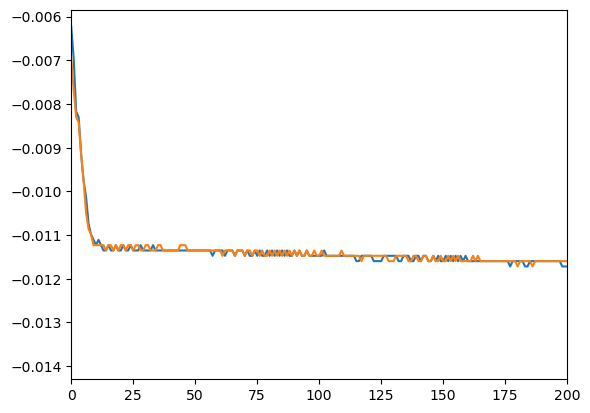

In [58]:
plt.plot(range(0,1095),np.array(progIW001_5m.rhopot0.mean(['xh','yh']).isel(zl=0)) - \
         np.array(progIW001.rhopot0.mean(['xh','yh']).isel(zl=0)),label=r'$1 \times 10^{-3}$')

plt.plot(range(0,1095),np.array(OprogIW001_5m.rhopot0.mean(['xh','yh']).isel(zl=0)) - \
         np.array(OprogIW001.rhopot0.mean(['xh','yh']).isel(zl=0)),label=r'$1 \times 10^{-3}$')
plt.xlim(0,200)

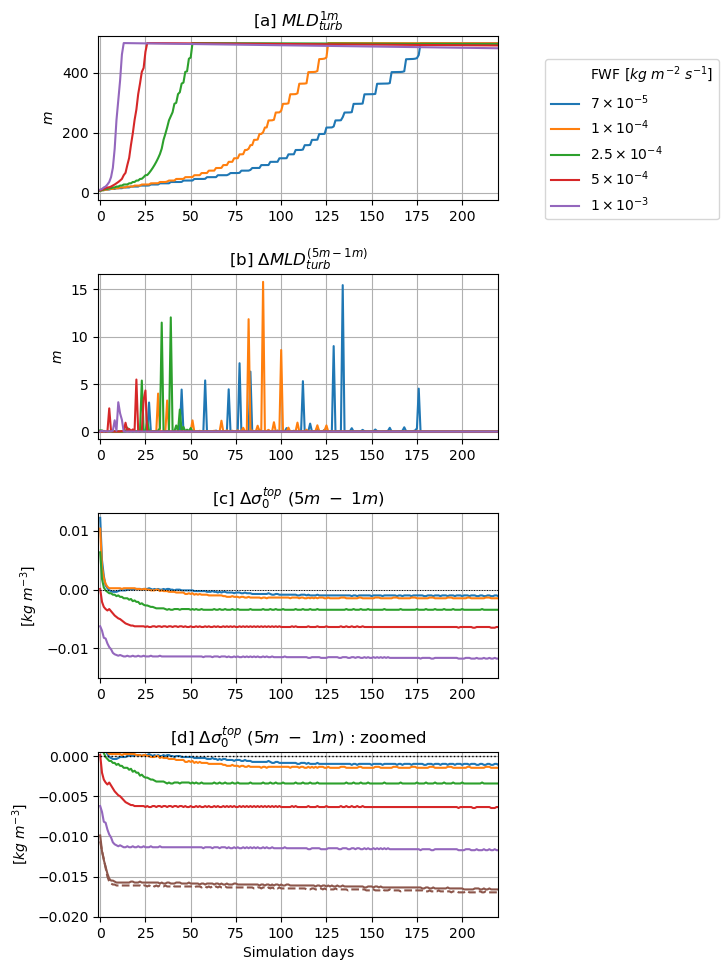

In [68]:
fig  = plt.figure(figsize = (5, 14))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

time_slice000=[-1,190+30]
depth_slicesurf_5m=slice(0,2.6)
depth_slicesurf=slice(0,0.6)

ax2 = plt.subplot(5,1,1)
plt.plot(0,0,color='white',label=r'FWF [$kg\ m^{-2}\ s^{-1}$]')
plt.plot(range(0,1095),np.array(progIW7em5.h_ML.mean(['xh','yh'])),label=r'$7 \times 10^{-5}$')
plt.plot(range(0,1095),np.array(progIW0001.h_ML.mean(['xh','yh'])),label=r'$1 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW00025.h_ML.mean(['xh','yh'])),label=r'$2.5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW0005.h_ML.mean(['xh','yh'])),label=r'$5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW001.h_ML.mean(['xh','yh'])),label=r'$1 \times 10^{-3}$')
# plt.plot(range(0,1095),np.array(S250progIW001.h_ML.mean(['xh','yh'])),label=r'$1 \times 10^{-3}$ 250')

#plt.plot([0,3600],[90,90],':',color='k')
x=[0,3600]
y0=[30,30]
y1=[80,80]
# ax2.fill_between(x, y0, y1,color='gold',alpha=0.3)

plt.title(r'[a] $MLD_{turb}^{1m}$')
plt.grid()
plt.xlim(time_slice000); plt.ylabel(r'$m$'); #plt.xlabel('Simulation days')
ax2.legend(bbox_to_anchor=(1.1, 0.9))



plt.subplot(5,1,2)
plt.plot(range(0,1095),np.array(progIW7em5_5m.h_ML.mean(['xh','yh'])) - \
         np.array(progIW7em5.h_ML.mean(['xh','yh'])),label=r'$7 \times 10^{-5}$')
plt.plot(range(0,1095),np.array(progIW0001_5m.h_ML.mean(['xh','yh'])) - \
         np.array(progIW0001.h_ML.mean(['xh','yh'])),label=r'$1 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW00025_5m.h_ML.mean(['xh','yh'])) -\
         np.array(progIW00025.h_ML.mean(['xh','yh'])),label=r'$2.5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW0005_5m.h_ML.mean(['xh','yh'])) - \
         np.array(progIW0005.h_ML.mean(['xh','yh'])),label=r'$5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW001_5m.h_ML.mean(['xh','yh'])) - \
         np.array(progIW001.h_ML.mean(['xh','yh'])),label=r'$1 \times 10^{-3}$')


plt.title(r'[b] $\Delta MLD_{turb}^{(5m-1m)}$')
plt.grid()
plt.xlim(time_slice000); plt.ylabel(r'$m$'); #plt.xlabel('Simulation days')


plt.subplot(5,1,3)

plt.plot(range(0,1095),np.array(progIW7em5_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW7em5.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$7 \times 10^{-5}$')
plt.plot(range(0,1095),np.array(progIW0001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$1 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW00025_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW00025.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$2.5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW0005_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0005.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$1 \times 10^{-3}$')


plt.plot([0,3600],[0,0],':',linewidth=0.7,color='k')
plt.title(r'[c] $\Delta \sigma_0^{top}\ (5m\ -\ 1m)\ $')
plt.grid(); plt.ylim(-0.015,0.013)
plt.xlim(time_slice000); plt.ylabel(r"$[kg\ m^{-3}]$"); 


plt.subplot(5,1,4)

plt.plot(range(0,1095),np.array(progIW7em5_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW7em5.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$7 \times 10^{-5}$')
plt.plot(range(0,1095),np.array(progIW0001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$1 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW00025_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW00025.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$2.5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW0005_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0005.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$1 \times 10^{-3}$')
plt.plot(range(0,1095),np.array(progIW0015_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0015.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$1.5 \times 10^{-3}$',color="tab:brown")
plt.plot(range(0,1095),np.array(MprogIW0015_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(MprogIW0015.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),'--',label=r'$1.5 \times 10^{-3}$ Orig mix',color="tab:brown")


plt.plot([0,3600],[0,0],':',linewidth=1,color='k')
plt.title(r'[d] $\Delta \sigma_0^{top}\ (5m\ -\ 1m)\ $: zoomed')
plt.grid(); plt.ylim(-0.02,0.0005)
plt.xlim(time_slice000); plt.ylabel(r"$[kg\ m^{-3}]$"); 
plt.xlabel('Simulation days')

# plt.subplot(5,1,5)

# plt.plot(range(0,1095),np.array(progIW7em5_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
#     np.array(progIW7em5.rhopot0.mean(['xh','yh']).isel(zl=-1)),label=r'$7 \times 10^{-5}$')
# plt.plot(range(0,1095),np.array(progIW0001_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
#     np.array(progIW0001.rhopot0.mean(['xh','yh']).isel(zl=-1)),label=r'$1 \times 10^{-4}$')
# plt.plot(range(0,1095),np.array(progIW00025_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
#     np.array(progIW00025.rhopot0.mean(['xh','yh']).isel(zl=-1)),label=r'$2.5 \times 10^{-4}$')
# plt.plot(range(0,1095),np.array(progIW0005_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
#     np.array(progIW0005.rhopot0.mean(['xh','yh']).isel(zl=-1)),label=r'$5 \times 10^{-4}$')
# plt.plot(range(0,1095),np.array(progIW001_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
#     np.array(progIW001.rhopot0.mean(['xh','yh']).isel(zl=-1)),label=r'$1 \times 10^{-3}$')


# plt.plot([0,3600],[0,0],':',linewidth=1,color='k')
# plt.title(r'[d] $\Delta \sigma_0^{bottom}\ (5m\ -\ 1m)\ $: zoomed')
# plt.grid(); #plt.ylim(-0.015,0.0005)
# plt.xlim(time_slice000); plt.ylabel(r"$[kg\ m^{-3}]$"); 
# plt.xlabel('Simulation days')


plt.savefig('/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/singlecolumn_MLDsigma_transientresponse_FWF.png', dpi=300, bbox_inches='tight')

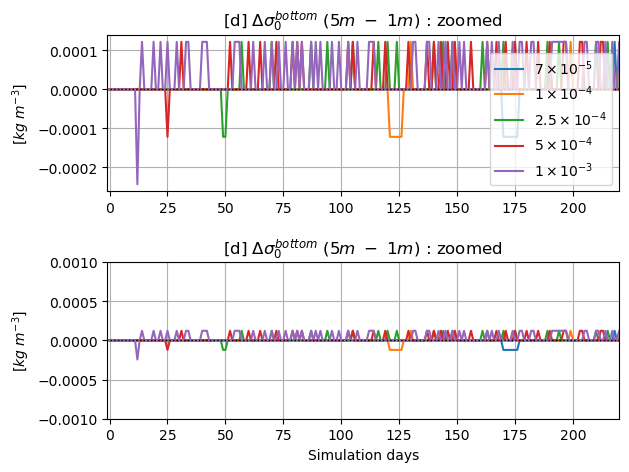

In [23]:
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)
ZB=-1
plt.subplot(2,1,1)
plt.plot(range(0,1095),np.array(progIW7em5_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW7em5.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$7 \times 10^{-5}$')
plt.plot(range(0,1095),np.array(progIW0001_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW0001.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$1 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW00025_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW00025.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$2.5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW0005_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW0005.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW001_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW001.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$1 \times 10^{-3}$')
# plt.plot(range(0,1095),np.array(S250progIW001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
#     np.array(S250progIW001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$1 \times 10^{-3}$ 250m')


plt.plot([0,3600],[0,0],':',linewidth=1,color='k')
plt.title(r'[d] $\Delta \sigma_0^{bottom}\ (5m\ -\ 1m)\ $: zoomed')
plt.grid(); #plt.ylim(-0.015,0.0005)
plt.xlim(time_slice000); plt.ylabel(r"$[kg\ m^{-3}]$"); 
plt.legend()

plt.subplot(2,1,2)
plt.plot(range(0,1095),np.array(progIW7em5_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW7em5.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$7 \times 10^{-5}$')
plt.plot(range(0,1095),np.array(progIW0001_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW0001.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$1 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW00025_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW00025.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$2.5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW0005_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW0005.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$5 \times 10^{-4}$')
plt.plot(range(0,1095),np.array(progIW001_5m.rhopot0.mean(['xh','yh']).isel(zl=ZB)) - \
    np.array(progIW001.rhopot0.mean(['xh','yh']).isel(zl=ZB)),label=r'$1 \times 10^{-3}$')
# plt.plot(range(0,1095),np.array(S250progIW001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
#     np.array(S250progIW001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')),label=r'$1 \times 10^{-3}$ 250m')


plt.plot([0,3600],[0,0],':',linewidth=1,color='k')
plt.title(r'[d] $\Delta \sigma_0^{bottom}\ (5m\ -\ 1m)\ $: zoomed')
plt.grid(); plt.ylim(-0.001,0.001)
plt.xlim(time_slice000); 
plt.ylabel(r"$[kg\ m^{-3}]$"); 
plt.xlabel('Simulation days')
plt.savefig('/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/singlecolumn_MLDsigma_transientresponse_FWFbottom.png', dpi=300, bbox_inches='tight')


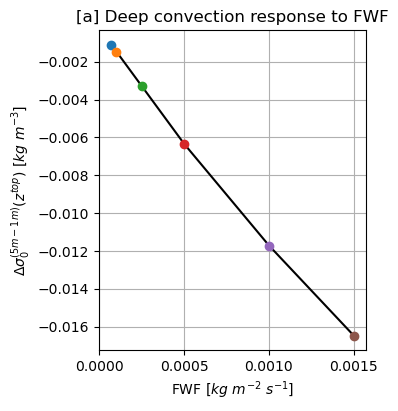

In [65]:
#let's see how a xy curve of FWF and deltasigma looks like
fig  = plt.figure(figsize = (8, 4))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)


FWFrate = [7e-5,1e-4,2.5e-4,5e-4,1e-3,1.5e-3] # FWF applied to the experiments
#below the response in 200, where all models MLD are equilibrated
daysel=20

#by timescale
s_low=(np.array(progIW7em5_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW7em5.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[daysel]
s_0001 =(np.array(progIW0001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[daysel]
s_00025 = (np.array(progIW00025_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW00025.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[daysel]
s_0005 = (np.array(progIW0005_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0005.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[daysel]
s_001 = (np.array(progIW001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0015.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[daysel]
s_0015 = (np.array(progIW0015_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0015.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[daysel]

dsigma=[s_low,s_0001,s_00025,s_0005,s_001,s_0015]

#by equilibrium
dayeq=200
se_low=(np.array(progIW7em5_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW7em5.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[dayeq]
se_0001 =(np.array(progIW0001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[dayeq]
se_00025 = (np.array(progIW00025_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW00025.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[dayeq]
se_0005 = (np.array(progIW0005_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0005.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[dayeq]
se_001 = (np.array(progIW001_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW001.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[dayeq]
se_0015 = (np.array(progIW0015_5m.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf_5m).weighted(dz5full).mean('zl')) - \
    np.array(progIW0015.rhopot0.mean(['xh','yh']).sel(zl=depth_slicesurf).weighted(dz1full).mean('zl')))[dayeq]

dsigmae=[se_low,se_0001,se_00025,se_0005,se_001,se_0015]

#by bottom
dayeq=200
sb_low=(np.array(progIW7em5_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
    np.array(progIW7em5.rhopot0.mean(['xh','yh']).isel(zl=-1)))[dayeq]
sb_0001 =(np.array(progIW0001_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
    np.array(progIW0001.rhopot0.mean(['xh','yh']).isel(zl=-1)))[dayeq]
sb_00025 = (np.array(progIW00025_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
    np.array(progIW00025.rhopot0.mean(['xh','yh']).isel(zl=-1)))[dayeq]
sb_0005 = (np.array(progIW0005_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
    np.array(progIW0005.rhopot0.mean(['xh','yh']).isel(zl=-1)))[dayeq]
sb_001 = (np.array(progIW001_5m.rhopot0.mean(['xh','yh']).isel(zl=-1)) - \
    np.array(progIW001.rhopot0.mean(['xh','yh']).isel(zl=-1)))[dayeq]

dsigmab=[sb_low,sb_0001,sb_00025,sb_0005,sb_001]

#1 - based on period of ~30 days ( period of sea ice formation)
plt.subplot(1,2,1)
plt.plot(FWFrate,dsigmae,color='k')
for n in range(6):
    plt.plot(FWFrate[n],dsigmae[n],marker='o')

plt.xlabel(r'FWF [$kg\ m^{-2}\ s^{-1}$]')
plt.ylabel(r'$\Delta \sigma_0^{(5m-1m)} (z^{top})\ [kg\ m^{-3}]$')
plt.title('[a] Deep convection response to FWF')
#2 - based on when the water column is in full convection
plt.grid()

# plt.subplot(1,2,2)
# plt.plot(FWFrate,dsigma,color='k')
# for n in range(6):
#     plt.plot(FWFrate[n],dsigma[n],marker='o')

# plt.xlabel(r'FWF [$kg\ m^{-2}\ s^{-1}$]')
# plt.ylabel(r'$\Delta \sigma_0^{(5m-1m)} (z^{top})\ [kg\ m^{-3}]$')
# plt.title('[b] ' + str(daysel) +' days response to FWF')
# plt.grid()

plt.savefig('/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/singlecolumn_surfsigma_response_FWF.png', dpi=300, bbox_inches='tight')

It seems that indeed a thinner top cell is benneficial to have a stronger effect of salinity on density, and beneficial to make SWMT create denser DSW. However the signal here is not that big. That could likely be because:

[a] The temperature is causing no trasformation in these experiments, when the water column is in deep convection. That is because when themodel gets to deep convection, the watter column is already homoneneously in the freezing point.

[b] No horizontal adivection ofwater masses exist. In the real Southern Ocean the descending surface dense waters would likely be replaced by adjacent waters through horizontala advection. These waters being horizontally adivected would likely come from water masses like CDW that are lighter. These would make the density transformation bigger

Caveat: no signal in the bottom density (is that because we are in continuous vertical mixing)?


Out of curiosity, how does $\sigma_0$ changes at the surface cells in OM2? is the maginitude change the same as pointed out by the SWMT?

In [78]:
#databases
gdata_db='/home/156/wf4500/databases/access/DSW.db'
temporary_db='/home/156/wf4500/databases/access/temporary_DSW.db'

temp_session = cc.database.create_session(temporary_db)
gdata_session = cc.database.create_session()

exp5mtop = 'ryf_5mtoponly'
exp5mtopgdata = '01deg_jra55v13_ryf9091_21mbath_5mtop'

expctrl = '01deg_jra55v13_ryf9091_21mbath'
exphalf = 'ryf_halfmtop'

#Density at surface
Wlatmax=-72; Wlonwest=-62; Wloneast=-30
CTRLsigma = cc.querying.getvar(expctrl, 'pot_rho_0', gdata_session , \
                               start_time='1909-05',end_time='1909-08',frequency='1 monthly')\
                                .isel(st_ocean=0)\
                                    .sel(yt_ocean=slice(-90,Wlatmax),xt_ocean=slice(Wlonwest,Wloneast))
R5sigma = cc.querying.getvar(exp5mtopgdata, 'pot_rho_0', gdata_session , \
                               start_time='1909-05',end_time='1909-08',frequency='1 monthly')\
                                .isel(st_ocean=0)\
                                    .sel(yt_ocean=slice(-90,Wlatmax),xt_ocean=slice(Wlonwest,Wloneast))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


0.3.0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


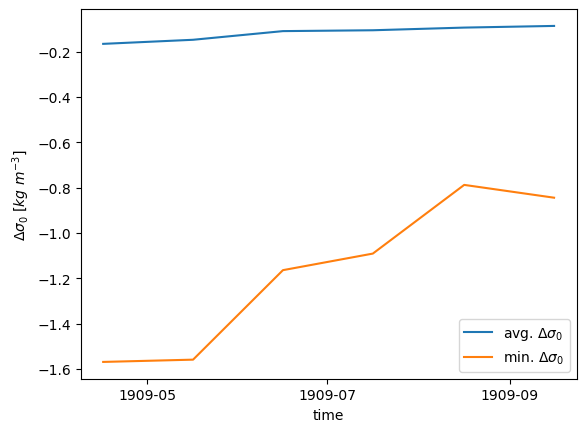

In [98]:
(R5sigma - CTRLsigma).mean(['xt_ocean','yt_ocean']).plot(label=r"avg. $\Delta \sigma_0$")
(R5sigma - CTRLsigma).min(['xt_ocean','yt_ocean']).plot(label=r"min. $\Delta \sigma_0$")
plt.ylabel(r"$\Delta \sigma_0\ [kg\ m^{-3}]$")
plt.legend()

This highlights that the desnity changes we have in the model at surface at yet even bigger

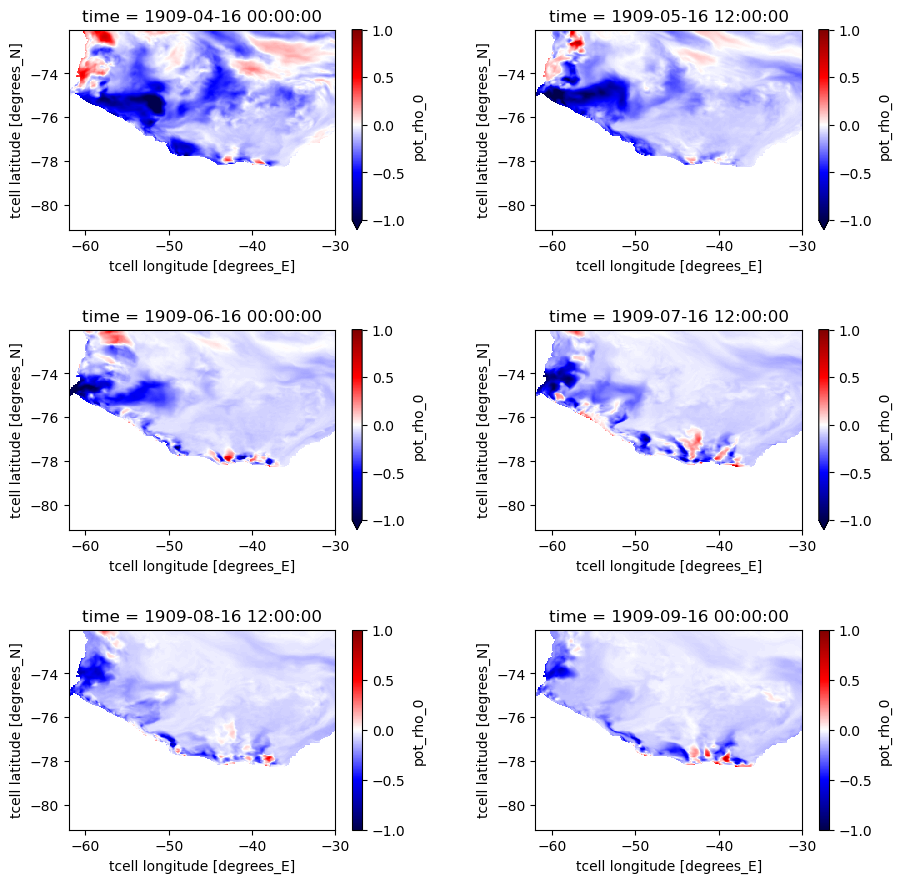

In [88]:
fig  = plt.figure(figsize = (10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

for n in range(0,6):
    plt.subplot(3,2,n+1)
    (R5sigma - CTRLsigma).isel(time=n).plot(vmin=-1,vmax=1,cmap='seismic')

### **Case 3** - Heat-driven convection

For this experiments, we will change the sensitive heat fluxes to increments of $-500:-100:-200\ W\ m^{-2}$, and the wind stress to two cases according to the two poles of deep convection change in the Labrador sea

**Pole 1, north**: $\tau_x^{N}=0.1\ N\ m^{-2}$ & $\tau_y^{N}=-0.04\ N\ m^{-2}$

**Pole 2, sorth**: $\tau_x^{S}=0.14\ N\ m^{-2}$ & $\tau_y^{S}=-0.003\ N\ m^{-2}$



case 3 part of this code will be divided into 2 parts

- **Part I**: Setting up boundary conditions, Initial conditions and vertical grid
- **Part II**: Output evaluation

##### **Part I**

Let's create the forcing data for the labrador heat-driven convection experiments

In [26]:
#zeroying out all forcings first
data_lab=data_orig.copy()
data_lab['precip'].values=np.array(data_orig.precip)*0
data_lab['snow'].values=np.array(data_orig.snow)*0
data_lab['shflx'].values=np.array(data_orig.shflx)*0
data_lab['lwdn_sfc'].values=np.array(data_orig.lwdn_sfc)*0
data_lab['lwup_sfc'].values=np.array(data_orig.lwup_sfc)*0
data_lab['netlwdn_sfc'].values=np.array(data_orig.netlwdn_sfc)*0
data_lab['swdn_sfc'].values=np.array(data_orig.swdn_sfc)*0
data_lab['swup_sfc'].values=np.array(data_orig.swup_sfc)*0
data_lab['netswdn_sfc'].values=np.array(data_orig.netswdn_sfc)*0
data_lab['STRESS_X'].values=(np.array(data_orig.STRESS_X)*0) 
data_lab['STRESS_Y'].values=(np.array(data_orig.STRESS_Y)*0) 
data_lab['evap'].values=(np.array(data_orig.evap)*0) 


#North centre 
data_labN=data_lab.copy()
data_labN['STRESS_X'].values=(np.array(data_orig.STRESS_X)*0)  + 0.1
data_labN['STRESS_Y'].values=(np.array(data_orig.STRESS_Y)*0)  -0.04
#South centre
data_labS=data_lab.copy()
data_labS['STRESS_X'].values=(np.array(data_orig.STRESS_X)*0)  + 0.14
data_labS['STRESS_Y'].values=(np.array(data_orig.STRESS_Y)*0)  -0.003


#now diving each centre into 5 cases according to the sensitivie heat flux categories


#north case
data_labN5=data_labN.copy()
data_labN5['shflx'].values=(np.array(data_orig.shflx)*0)  +500
data_labN4=data_labN.copy()
data_labN4['shflx'].values=(np.array(data_orig.shflx)*0)  +400
data_labN3=data_labN.copy()
data_labN3['shflx'].values=(np.array(data_orig.shflx)*0)  +300
data_labN2=data_labN.copy()
data_labN2['shflx'].values=(np.array(data_orig.shflx)*0)  +200


#south case
data_labS5=data_labS.copy()
data_labS5['shflx'].values=(np.array(data_orig.shflx)*0)  +500
data_labS4=data_labS.copy()
data_labS4['shflx'].values=(np.array(data_orig.shflx)*0)  +400
data_labS3=data_labS.copy()
data_labS3['shflx'].values=(np.array(data_orig.shflx)*0)  +300
data_labS2=data_labS.copy()
data_labS2['shflx'].values=(np.array(data_orig.shflx)*0)  +200

Saving Labrador sea forcing...

In [27]:
#Saved after the name
data_labN5.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LabN5.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_labN4.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LabN4.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_labN3.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LabN3.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_labN2.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LabN2.nc',format="NETCDF3_CLASSIC",encoding=encoding)


data_labS5.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LabS5.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_labS4.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LabS4.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_labS3.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LabS3.nc',format="NETCDF3_CLASSIC",encoding=encoding)
data_labS2.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LabS2.nc',format="NETCDF3_CLASSIC",encoding=encoding)

creating the IC for labrador se experiments, based on OM2 IC

In [28]:
Lab_srcIC_N='/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/local_input/Lab_IC_N.nc'
Lab_srcIC_S='/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/local_input/Lab_IC_S.nc'
IC_LabIn_N=xr.open_dataset(Lab_srcIC_N)
IC_LabIn_S=xr.open_dataset(Lab_srcIC_S)

In [29]:
############   shelf conditions
#Creating the new IC conditons
IC_Lab_out = IC_orig.copy()
#setting boundaries. This is important so we can input the proper Lon and Lat on MOM_input
IC_Lab_out['LAT']=[-85,85]
IC_Lab_out['LON']=[-180,180]
# expanding the number of depth levels and setting the corrent values for PTEMP and SALT
IC_Lab_out = IC_Lab_out.interp(DEPTH=np.array(IC_LabIn_N.st_ocean))
IC_Lab_out['PTEMP'].values=np.transpose(np.tile(np.array(IC_LabIn_N.PTemp),[12,2,2,1]),[0,3,1,2])
IC_Lab_out['PTEMP'].values=IC_Lab_out.PTEMP.ffill(dim='DEPTH')
IC_Lab_out['SALT'].values=np.transpose(np.tile(np.array(IC_LabIn_N.Salinity),[12,2,2,1]),[0,3,1,2])
IC_Lab_out['SALT'].values=IC_Lab_out.SALT.ffill(dim='DEPTH')
#setting Boundary depths
boundaries_St=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_KDS75.nc').st_edges_ocean
boundaries_St=np.array([np.array(boundaries_St[:-1]), np.array(boundaries_St[1:])]).T
IC_Lab_out['DEPTH_bnds'].values=boundaries_St

IC_Lab_out.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/BATS/LAB_OM2_columnIC.nc',format="NETCDF3_CLASSIC",encoding=Wencoding)


Cutting the vertical grid to have $3500\ m$ depth

In [30]:
#original KDS grid with 6 km depth
kds_6km = xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_KDS75.nc')
#new KDS grid 1mtop with 1km depth
depth_slice=slice(0,3500)
kds_35km = kds_6km.copy().sel(st_ocean=depth_slice).sel(st_edges_ocean=depth_slice)
kds_35km.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_1mtop_35km.nc')
#new KDS grid 1mtop with 1km depth
depth_slice3=slice(0,670)
kds_650m = kds_6km.copy().sel(st_ocean=depth_slice3).sel(st_edges_ocean=depth_slice3)
kds_650m.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_1mtop_650m.nc')
kds_650m

#new KDS grid 1mtop with 1km depth
depth_slice4=slice(0,1550)
kds_1500m = kds_6km.copy().sel(st_ocean=depth_slice4).sel(st_edges_ocean=depth_slice4)
kds_1500m.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_1mtop_1500m.nc')
kds_1500m


#new KDS grid 5mtop
kds_5mtop_6km=  xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_5mtop.nc')
kds_5mtop_35km = kds_5mtop_6km.copy().sel(st_ocean=depth_slice).sel(st_edges_ocean=depth_slice)
kds_5mtop_35km.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_5mtop_35km.nc')
#new KDS grid 1mtop with 1km depth
kds_5mtop_650m = kds_5mtop_6km.copy().sel(st_ocean=depth_slice3).sel(st_edges_ocean=depth_slice3)
kds_5mtop_650m.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_5mtop_650m.nc')
kds_5mtop_650m

#new KDS grid 1mtop with 1km depth
kds_5mtop_1500m = kds_5mtop_6km.copy().sel(st_ocean=depth_slice4).sel(st_edges_ocean=depth_slice4)
kds_5mtop_1500m.to_netcdf('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/INPUT/vcoord_5mtop_1500m.nc')
kds_5mtop_1500m


<xarray.Dataset>
Dimensions:         (st_edges_ocean: 49, st_ocean: 48)
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 5.062 ... 1.391e+03 1.515e+03
  * st_ocean        (st_ocean) float64 2.531 5.869 7.569 ... 1.333e+03 1.453e+03
Data variables:
    *empty*
Attributes:
    filename:   ocean.nc
    title:      ACCESS-OM2-01
    grid_type:  mosaic
    grid_tile:  1
    history:    Thu Jan 21 08:51:33 2021: ncks -v st_ocean,st_edges_ocean /g/...
    NCO:        netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net,...

We can finally run the experiments

##### **Part II**

In [31]:
####### 1mtop - North convection

#importing surfae forcing data
surffluxesN2=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N20/surffluxes.nc')
surffluxesN3=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N30/surffluxes.nc')
surffluxesN4=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N40/surffluxes.nc')
surffluxesN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50/surffluxes.nc')
S1500surffluxesN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50_1500m/surffluxes.nc') #1500m depth

# Importing output vars
##aveprog
ave_progN2=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N20/ave_prog.nc')
ave_progN3=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N30/ave_prog.nc')
ave_progN4=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N40/ave_prog.nc')
ave_progN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50/ave_prog.nc')
S1500ave_progN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50_1500m/ave_prog.nc')

##prog
progN2=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N20/prog.nc')
progN3=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N30/prog.nc')
progN4=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N40/prog.nc')
progN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50/prog.nc')
S1500progN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50_1500m/prog.nc')

##progz
progzN2=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N20/prog_z.nc')
progzN3=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N30/prog_z.nc')
progzN4=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N40/prog_z.nc')
progzN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50/prog_z.nc')
S1500progzN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50_1500m/prog_z.nc')


##visc
viscN2=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N20/visc.nc')
viscN3=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N30/visc.nc')
viscN4=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N40/visc.nc')
viscN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50/visc.nc')
S1500viscN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50_1500m/visc.nc')

##static
statsN2=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N20/ocean.stats.nc')
statsN3=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N30/ocean.stats.nc')
statsN4=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N40/ocean.stats.nc')
statsN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50/ocean.stats.nc')
S1500statsN5=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_1mtop_N50_1500m/ocean.stats.nc')

In [32]:
####### 5mtop  - North convection

#importing surfae forcing data
surffluxesN2_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N20/surffluxes.nc')
surffluxesN3_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N30/surffluxes.nc')
surffluxesN4_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N40/surffluxes.nc')
surffluxesN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50/surffluxes.nc')
S1500surffluxesN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50_1500m/surffluxes.nc') #1500m depth

# Importing output vars
##aveprog
ave_progN2_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N20/ave_prog.nc')
ave_progN3_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N30/ave_prog.nc')
ave_progN4_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N40/ave_prog.nc')
ave_progN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50/ave_prog.nc')
S1500ave_progN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50_1500m/ave_prog.nc') 

##prog
progN2_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N20/prog.nc')
progN3_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N30/prog.nc')
progN4_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N40/prog.nc')
progN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50/prog.nc')
S1500progN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50_1500m/prog.nc')

##progz
progzN2_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N20/prog_z.nc')
progzN3_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N30/prog_z.nc')
progzN4_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N40/prog_z.nc')
progzN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50/prog_z.nc')
S1500progzN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50_1500m/prog_z.nc')

##visc
viscN2_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N20/visc.nc')
viscN3_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N30/visc.nc')
viscN4_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N40/visc.nc')
viscN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50/visc.nc')
S1500viscN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50_1500m/visc.nc')

##static
statsN2_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N20/ocean.stats.nc')
statsN3_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N30/ocean.stats.nc')
statsN4_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N40/ocean.stats.nc')
statsN5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50/ocean.stats.nc')
S1500N5_5m=xr.open_dataset('/g/data/v45/wf4500/MOM6_ocean_only/MOM6-examples/ocean_only/single_column/EPBL/archive/Experiments_out/Labrador/output_5mtop_N50_1500m/ocean.stats.nc')

Was teh sensible heat forcing applied correctly?

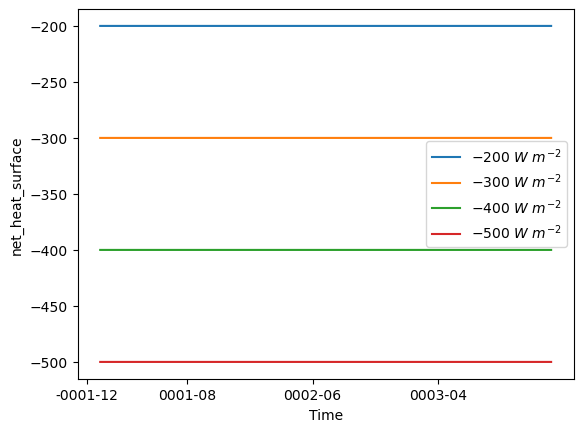

In [33]:
surffluxesN2.net_heat_surface.mean(['xh','yh']).plot(label=r"$-200\ W\ m^{-2}$")
surffluxesN3.net_heat_surface.mean(['xh','yh']).plot(label=r"$-300\ W\ m^{-2}$")
surffluxesN4.net_heat_surface.mean(['xh','yh']).plot(label=r"$-400\ W\ m^{-2}$")
surffluxesN5.net_heat_surface.mean(['xh','yh']).plot(label=r"$-500\ W\ m^{-2}$")
plt.legend()


How long it takes for each forcing to cause deep convection?

Text(0, 0.5, '$\\Delta \\sigma_0^{top}\\ (5m\\ -\\ 1m)\\ $')

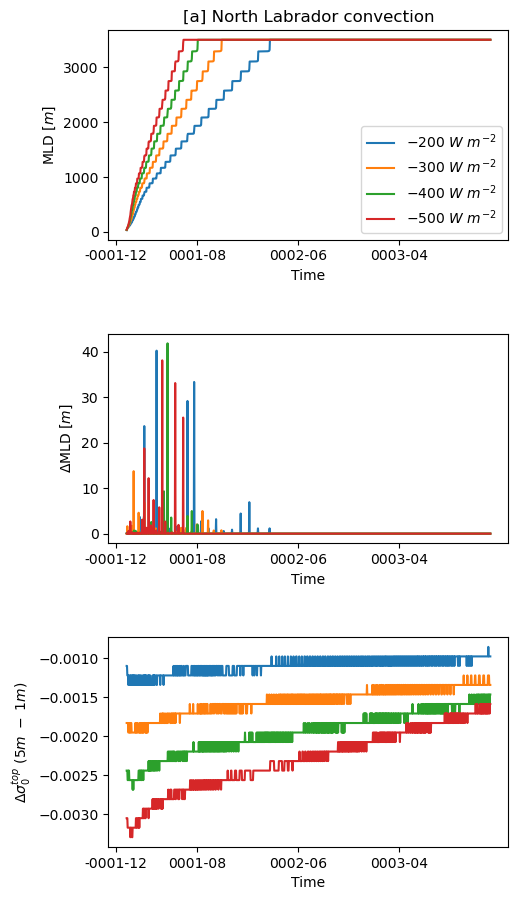

In [34]:
fig  = plt.figure(figsize = (5, 14))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)


plt.subplot(4,1,1)
progN2.h_ML.mean(['xh','yh']).plot(label=r"$-200\ W\ m^{-2}$")
progN3.h_ML.mean(['xh','yh']).plot(label=r"$-300\ W\ m^{-2}$")
progN4.h_ML.mean(['xh','yh']).plot(label=r"$-400\ W\ m^{-2}$")
progN5.h_ML.mean(['xh','yh']).plot(label=r"$-500\ W\ m^{-2}$")
# S1500progN5.h_ML.mean(['xh','yh']).plot(label=r"$-500\ W\ m^{-2}$, 1500m")
plt.ylabel(r"MLD $[m]$"); plt.legend()
plt.title(r"[a] North Labrador convection")

plt.subplot(4,1,2)
(progN2_5m.h_ML - progN2.h_ML).mean(['xh','yh']).plot()
(progN3_5m.h_ML - progN3.h_ML).mean(['xh','yh']).plot()
(progN4_5m.h_ML - progN4.h_ML).mean(['xh','yh']).plot()
(progN5_5m.h_ML - progN5.h_ML).mean(['xh','yh']).plot()
plt.ylabel(r"$\Delta$MLD $[m]$")


plt.subplot(4,1,3)
(progN2_5m.rhopot0.sel(zl=depth_slicesurf_5m).mean('zl').mean(['xh','yh']) - \
 progN2.rhopot0.sel(zl=depth_slicesurf).mean('zl').mean(['xh','yh']))\
    .plot()
(progN3_5m.rhopot0.sel(zl=depth_slicesurf_5m).mean('zl').mean(['xh','yh']) - \
 progN3.rhopot0.sel(zl=depth_slicesurf).mean('zl').mean(['xh','yh']))\
    .plot()
(progN4_5m.rhopot0.sel(zl=depth_slicesurf_5m).mean('zl').mean(['xh','yh']) - \
 progN4.rhopot0.sel(zl=depth_slicesurf).mean('zl').mean(['xh','yh']))\
    .plot()
(progN5_5m.rhopot0.sel(zl=depth_slicesurf_5m).mean('zl').mean(['xh','yh']) - \
 progN5.rhopot0.sel(zl=depth_slicesurf).mean('zl').mean(['xh','yh']))\
    .plot()
# (S1500progN5_5m.rhopot0.sel(zl=depth_slicesurf_5m).mean('zl').mean(['xh','yh']) - \
#  S1500progN5.rhopot0.sel(zl=depth_slicesurf).mean('zl').mean(['xh','yh']))\
#     .plot()

plt.ylabel(r'$\Delta \sigma_0^{top}\ (5m\ -\ 1m)\ $')

The signal seem to go in the same direction as the salinity-driven convection case, but it has a much smaller magnitude. Why? perhaps the model is set up to be too deep, and instead of setting up the maximum depth as the ocean floor depth, we should set up the model maximum depth to the depth of deep conevction in each of the poles?

Possible next steps......

- perhaps rerun the models setting up maximum column depth to the depth of deep convection in the Labrador sea? (i.e., between 1km and 1.7km)

- hit the model with stronger net heat fluxes?

- rerun Southern ocean and Labrador experiments with a non-reentrant domain?

- rerun Southern ocean and Labrador experiments setting up the maximum depth as the maximum convection depth in each location?

- ideas?

(1500.0, 0.0)

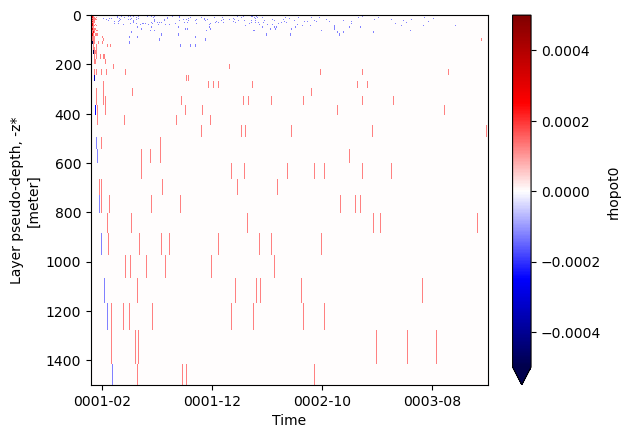

In [35]:
(S1500progN5_5m.rhopot0.mean(['xh','yh']) - \
 S1500progN5.rhopot0.mean(['xh','yh'])).plot(y='zl',vmin=-5e-4,vmax=5e-4,cmap='seismic')
plt.ylim(1500,0)

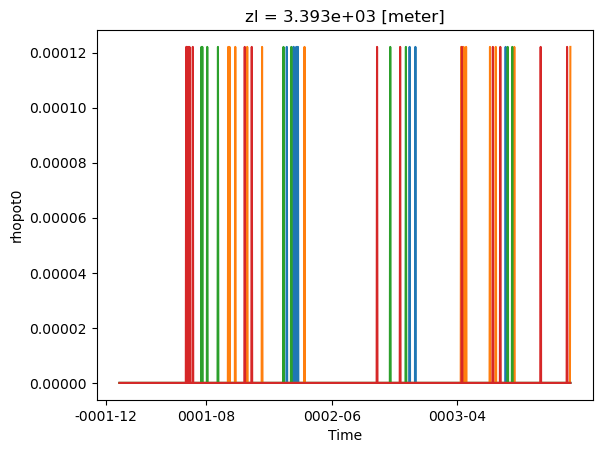

In [36]:
ZL=-1
(progN2_5m.rhopot0.isel(zl=-1).mean(['xh','yh']) - \
 progN2.rhopot0.isel(zl=-1).mean(['xh','yh']))\
    .plot()
(progN3_5m.rhopot0.isel(zl=-1).mean(['xh','yh']) - \
 progN3.rhopot0.isel(zl=-1).mean(['xh','yh']))\
    .plot()
(progN4_5m.rhopot0.isel(zl=-1).mean(['xh','yh']) - \
 progN4.rhopot0.isel(zl=-1).mean(['xh','yh']))\
    .plot()
(progN5_5m.rhopot0.isel(zl=-1).mean(['xh','yh']) - \
 progN5.rhopot0.isel(zl=-1).mean(['xh','yh']))\
    .plot()
# (S1500progN5_5m.rhopot0.isel(zl=-1).mean(['xh','yh']) - \
#  S1500progN5.rhopot0.isel(zl=-1).mean(['xh','yh']))\
#     .plot()

Text(0.5, 1.0, 'Labrador N5 experiment')

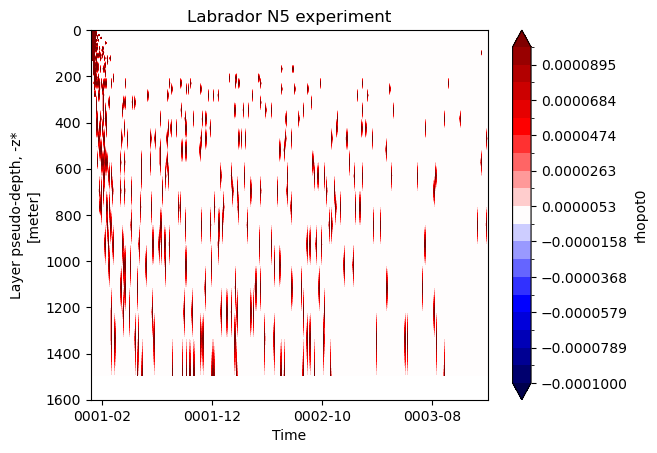

In [37]:
(S1500progN5_5m.rhopot0.mean(['xh','yh']) - \
 S1500progN5.rhopot0.mean(['xh','yh']))\
    .plot.contourf(x='Time',levels=np.linspace(-1e-4,1e-4,20),cmap='seismic')
plt.ylim(1600,0)
plt.title(r"Labrador N5 experiment")

Text(0.5, 1.0, 'Labrador N5 experiment')

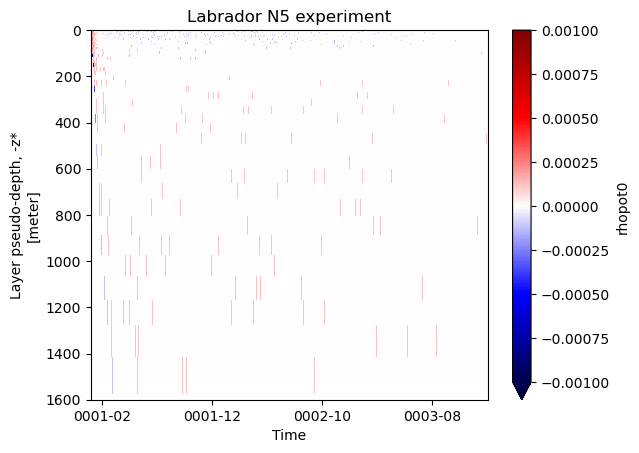

In [38]:
(S1500progN5_5m.rhopot0.mean(['xh','yh']) - \
 S1500progN5.rhopot0.mean(['xh','yh']))\
    .plot.pcolormesh(x='Time',vmin=-1e-3,vmax=1e-3,cmap='seismic')
plt.ylim(1600,0)
plt.title(r"Labrador N5 experiment")

Text(0.5, 1.0, 'Weddell 0.01 experiment')

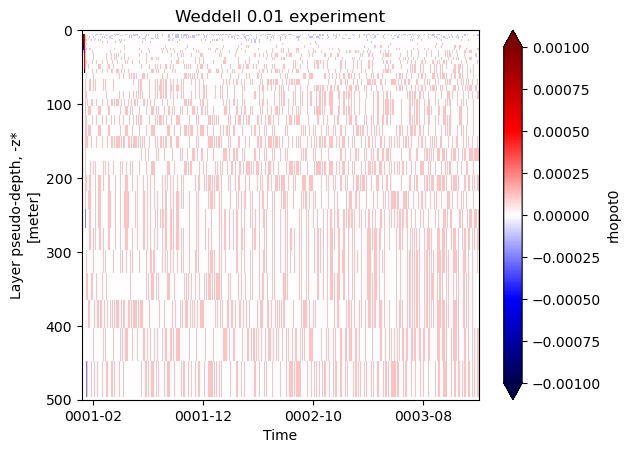

In [39]:
(progIW001_5m.rhopot0.mean(['xh','yh']) - \
 progIW001.rhopot0.mean(['xh','yh']))\
    .plot.pcolormesh(x='Time',vmin=-1e-3,vmax=1e-3,cmap='seismic')
plt.ylim(500,0)
plt.title(r"Weddell 0.01 experiment")